In [21]:
import wandb
import ast
import argparse
import os
from lineflow.helpers import get_device
from lineflow.learning.helpers import (
    make_stacked_vec_env,
)
from lineflow.learning.curriculum import CurriculumLearningCallback
from lineflow.examples import (
    WaitingTime,
    ComplexLine,
    WaterLine
)
import torch
import numpy as np
from torch_geometric.data import HeteroData
from wandb.integration.sb3 import WandbCallback
import networkx as nx
import matplotlib.pyplot as plt
from gymnasium import spaces
import stable_baselines3

## Load line data

In [180]:
dataset = torch.load('../data/complex_line_graph_n_assemblies5_waiting_time5_stepsize_1.pt', weights_only=False)

## Helper functions to convert the heterogeneous graph structure to dictionary
### Current simulation pipeline
Lineflow 
-> graph states (type:HeteroData) 
-> dictionary (type:space.Dict) containing all the node, edge infos of the graph 
-> SB3 
-> feature extraction 
-> dictionary states containing the graph info has to return back to the heterogeneous graph state for GNN to operate 
-> action 
-> Lineflow

In [24]:
def _convert_hetero_graph_to_flat_vector(hetero_data, max_nodes_per_type=None, max_edges_per_type=None):
    """
    Convert HeteroData to a single flat vector for Stable Baselines3 observation space.
    
    Args:
        hetero_data: HeteroData object
        max_nodes_per_type: Dict[str, int] - Maximum number of nodes per type (for padding)
        max_edges_per_type: Dict[tuple, int] - Maximum number of edges per type (for padding)
    
    Returns:
        np.ndarray: Flat vector representation
        dict: Metadata for reconstruction (shapes, types, etc.)
    """
    flat_components = []
    metadata = {
        'node_info': {},
        'edge_info': {},
        'total_length': 0,
        'component_order': []
    }
    
    # Process node features
    for node_type in sorted(hetero_data.node_types):  # Sort for consistency
        if node_type in hetero_data.x_dict and hetero_data.x_dict[node_type].shape[0] > 0:
            node_features = hetero_data.x_dict[node_type]
            if isinstance(node_features, torch.Tensor):
                node_features = node_features.detach().cpu().numpy()
            
            # Store metadata
            original_shape = node_features.shape
            feature_dim = original_shape[1] if len(original_shape) > 1 else 1
            
            # Apply padding if max_nodes specified
            if max_nodes_per_type and node_type in max_nodes_per_type:
                max_nodes = max_nodes_per_type[node_type]
                if original_shape[0] < max_nodes:
                    # Pad with zeros
                    padded_shape = (max_nodes, feature_dim)
                    padded_features = np.zeros(padded_shape, dtype=np.float32)
                    padded_features[:original_shape[0]] = node_features
                    node_features = padded_features
                elif original_shape[0] > max_nodes:
                    # Truncate
                    node_features = node_features[:max_nodes]
            
            # Flatten and add to components
            flat_features = node_features.flatten()
            flat_components.append(flat_features)
            
            # Store metadata
            metadata['node_info'][node_type] = {
                'start_idx': len(np.concatenate(flat_components[:-1])) if len(flat_components) > 1 else 0,
                'length': len(flat_features),
                'original_shape': original_shape,
                'padded_shape': node_features.shape,
                'feature_dim': feature_dim
            }
            metadata['component_order'].append(('node', node_type))
    
    # Process edge indices
    for edge_type in sorted(hetero_data.edge_types):  # Sort for consistency
        if edge_type in hetero_data.edge_index_dict:
            edge_index = hetero_data.edge_index_dict[edge_type]
            if isinstance(edge_index, torch.Tensor):
                edge_index = edge_index.detach().cpu().numpy()
            
            if edge_index.shape[1] > 0:  # Only if there are edges
                original_shape = edge_index.shape  # Should be [2, num_edges]
                
                # Apply padding if max_edges specified
                if max_edges_per_type and edge_type in max_edges_per_type:
                    max_edges = max_edges_per_type[edge_type]
                    if original_shape[1] < max_edges:
                        # Pad with -1 (invalid edge index)
                        padded_shape = (2, max_edges)
                        padded_edges = np.full(padded_shape, -1, dtype=np.int64)
                        padded_edges[:, :original_shape[1]] = edge_index
                        edge_index = padded_edges
                    elif original_shape[1] > max_edges:
                        # Truncate
                        edge_index = edge_index[:, :max_edges]
                
                # Flatten and add to components
                flat_edges = edge_index.flatten().astype(np.float32)  # Convert to float for consistency
                flat_components.append(flat_edges)
                
                # Store metadata
                current_start = sum(len(comp) for comp in flat_components[:-1])
                metadata['edge_info'][edge_type] = {
                    'start_idx': current_start,
                    'length': len(flat_edges),
                    'original_shape': original_shape,
                    'padded_shape': edge_index.shape,
                    'type': 'edge_index'
                }
                metadata['component_order'].append(('edge_index', edge_type))
        
        # Process edge attributes if they exist
        edge_store = hetero_data[edge_type]
        if hasattr(edge_store, 'edge_attr') and edge_store.edge_attr is not None:
            edge_attr = edge_store.edge_attr
            if isinstance(edge_attr, torch.Tensor):
                edge_attr = edge_attr.detach().cpu().numpy()
            
            if edge_attr.shape[0] > 0:  # Only if there are edge attributes
                original_shape = edge_attr.shape
                feature_dim = original_shape[1] if len(original_shape) > 1 else 1
                
                # Apply padding if max_edges specified (same as edge_index)
                if max_edges_per_type and edge_type in max_edges_per_type:
                    max_edges = max_edges_per_type[edge_type]
                    if original_shape[0] < max_edges:
                        # Pad with zeros
                        padded_shape = (max_edges, feature_dim)
                        padded_attr = np.zeros(padded_shape, dtype=np.float32)
                        padded_attr[:original_shape[0]] = edge_attr
                        edge_attr = padded_attr
                    elif original_shape[0] > max_edges:
                        # Truncate
                        edge_attr = edge_attr[:max_edges]
                
                # Flatten and add to components
                flat_attr = edge_attr.flatten()
                flat_components.append(flat_attr)
                
                # Store metadata
                current_start = sum(len(comp) for comp in flat_components[:-1])
                edge_attr_key = f"{edge_type}_attr"
                metadata['edge_info'][edge_attr_key] = {
                    'start_idx': current_start,
                    'length': len(flat_attr),
                    'original_shape': original_shape,
                    'padded_shape': edge_attr.shape,
                    'feature_dim': feature_dim,
                    'type': 'edge_attr'
                }
                metadata['component_order'].append(('edge_attr', edge_type))
    
    # Concatenate all components
    if flat_components:
        flat_vector = np.concatenate(flat_components).astype(np.float32)
    else:
        flat_vector = np.array([], dtype=np.float32)
    
    metadata['total_length'] = len(flat_vector)
    
    return flat_vector, metadata

def _convert_flat_vector_to_hetero_graph(flat_vector, metadata):
    """
    Convert flat vector back to HeteroData object.
    
    Args:
        flat_vector: np.ndarray - Flat vector representation
        metadata: dict - Metadata from the forward conversion
    
    Returns:
        HeteroData: Reconstructed heterogeneous graph
    """
    hetero_data = HeteroData()
    
    # Reconstruct node features
    for node_type, info in metadata['node_info'].items():
        start_idx = info['start_idx']
        length = info['length']
        padded_shape = info['padded_shape']
        original_shape = info['original_shape']
        
        # Extract the flat data
        flat_data = flat_vector[start_idx:start_idx + length]
        
        # Reshape to padded shape
        reshaped_data = flat_data.reshape(padded_shape)
        
        # Remove padding to get original shape
        if padded_shape != original_shape:
            reshaped_data = reshaped_data[:original_shape[0]]
        
        # Convert to tensor and add to hetero_data
        hetero_data[node_type].x = torch.tensor(reshaped_data, dtype=torch.float32)
    
    # Reconstruct edge indices and attributes
    for edge_info_key, info in metadata['edge_info'].items():
        start_idx = info['start_idx']
        length = info['length']
        padded_shape = info['padded_shape']
        original_shape = info['original_shape']
        
        # Extract the flat data
        flat_data = flat_vector[start_idx:start_idx + length]
        
        if info['type'] == 'edge_index':
            edge_type = edge_info_key
            
            # Reshape to padded shape
            reshaped_data = flat_data.reshape(padded_shape).astype(np.int64)
            
            # Remove padding (edges with -1 indices)
            if padded_shape != original_shape:
                # Find valid edges (not -1)
                valid_mask = reshaped_data[0] != -1
                reshaped_data = reshaped_data[:, valid_mask]
            
            # Convert to tensor and add to hetero_data
            hetero_data[edge_type].edge_index = torch.tensor(reshaped_data, dtype=torch.long)
            
        elif info['type'] == 'edge_attr':
            # Extract edge_type from the key (remove '_attr' suffix)
            edge_type = edge_info_key[:-5] if edge_info_key.endswith('_attr') else edge_info_key
            edge_type = eval(edge_type) if isinstance(edge_type, str) and edge_type.startswith('(') else edge_type
            
            # Reshape to padded shape
            reshaped_data = flat_data.reshape(padded_shape)
            
            # Remove padding to get original shape
            if padded_shape != original_shape:
                reshaped_data = reshaped_data[:original_shape[0]]
            
            # Convert to tensor and add to hetero_data
            hetero_data[edge_type].edge_attr = torch.tensor(reshaped_data, dtype=torch.float32)
    
    return hetero_data


In [32]:
n_cells = 4
line = ComplexLine(
        alternate=False,
        n_assemblies=n_cells,
        n_workers=3*n_cells,
        scrap_factor=1/n_cells,
        step_size=10,
        info=[],
        use_graph_as_states=True,
        )
env = make_stacked_vec_env(
        line=line,
        simulation_end=4000,
        reward="parts",
        n_envs=1,
        n_stack=1,
        track_states=['S_component']
    )
sample_state = line._graph_states

In [33]:
sample_state

HeteroData(
  Magazine={ x=[1, 2] },
  WorkerPool={ x=[1, 15] },
  Sink={ x=[1, 1] },
  Buffer={ x=[11, 2] },
  Source={ x=[1, 3] },
  Switch={ x=[1, 3] },
  Assembly={ x=[4, 4] },
  (WorkerPool, assignedto, Assembly)={
    edge_index=[2, 4],
    edge_attr=[4, 2],
  },
  (Assembly, assignedfrom, WorkerPool)={
    edge_index=[2, 4],
    edge_attr=[4, 3],
  },
  (Sink, feedsinto, Buffer)={
    edge_index=[2, 1],
    edge_attr=[1, 0],
  },
  (Buffer, upstream, Sink)={
    edge_index=[2, 1],
    edge_attr=[1, 0],
  },
  (Buffer, feedsfrom, Magazine)={
    edge_index=[2, 1],
    edge_attr=[1, 0],
  },
  (Magazine, upstream, Buffer)={
    edge_index=[2, 1],
    edge_attr=[1, 0],
  },
  (Source, feedsinto, Buffer)={
    edge_index=[2, 1],
    edge_attr=[1, 0],
  },
  (Buffer, upstream, Source)={
    edge_index=[2, 1],
    edge_attr=[1, 0],
  },
  (Buffer, switchesfrom, Switch)={
    edge_index=[2, 1],
    edge_attr=[1, 1],
  },
  (Switch, upstream, Buffer)={
    edge_index=[2, 1],
    edge_at

## helper to compare Heterodata

In [34]:
def compare_hetero_data(
    data_a,
    data_b,
    atol: float = 1e-6,
    rtol: float = 1e-5,
    ignore_edge_order: bool = False,
    verbose: bool = True,
):
    """
    Compare two torch_geometric.data.HeteroData objects.

    Args:
        data_a, data_b: HeteroData
        atol, rtol: Tolerances for numerical comparison
        ignore_edge_order: If True, edge_index columns are treated as an (ordered) multiset
        verbose: Print a human readable diff

    Returns:
        equal (bool), report (dict)
    """
    report = {
        "node_type_mismatch": None,
        "edge_type_mismatch": None,
        "nodes": {},
        "edges": {},
        "summary": {}
    }

    equal = True

    # --- Helper functions ---
    def to_tensor(x):
        if x is None:
            return None
        if not isinstance(x, torch.Tensor):
            x = torch.as_tensor(x)
        return x

    def numeric_diff(t1, t2):
        if t1.dtype != t2.dtype:
            return {"equal": False, "reason": f"dtype {t1.dtype} != {t2.dtype}"}
        if t1.shape != t2.shape:
            return {"equal": False, "reason": f"shape {tuple(t1.shape)} != {tuple(t2.shape)}"}
        diff = torch.abs(t1 - t2)
        max_abs = diff.max().item() if diff.numel() > 0 else 0.0
        rel = diff / (torch.abs(t2) + atol)
        max_rel = rel.max().item() if rel.numel() > 0 else 0.0
        ok = torch.allclose(t1, t2, atol=atol, rtol=rtol)
        return {
            "equal": bool(ok),
            "max_abs_diff": float(max_abs),
            "max_rel_diff": float(max_rel)
        }

    def normalize_edge_index(ei: torch.Tensor):
        # ei: [2, E]; produce sorted columns for order-insensitive comparison
        if ei.numel() == 0:
            return ei
        cols = ei.t()  # [E,2]
        # Sort by (src,dst)
        order = torch.lexsort((cols[:,1], cols[:,0])) if hasattr(torch, "lexsort") else \
            torch.argsort(cols[:,0]* (cols[:,0].max()+1) + cols[:,1])
        return cols[order].t()

    # --- Node types ---
    a_node_types = set(data_a.node_types)
    b_node_types = set(data_b.node_types)
    if a_node_types != b_node_types:
        equal = False
        report["node_type_mismatch"] = {
            "only_in_a": sorted(a_node_types - b_node_types),
            "only_in_b": sorted(b_node_types - a_node_types)
        }

    # Compare nodes present in both
    for nt in sorted(a_node_types & b_node_types):
        xa = data_a[nt].x if 'x' in data_a[nt] else None
        xb = data_b[nt].x if 'x' in data_b[nt] else None
        entry = {}
        if xa is None and xb is None:
            entry["status"] = "both_missing"
        elif (xa is None) != (xb is None):
            entry["status"] = "one_missing"
            equal = False
        else:
            xa_t, xb_t = to_tensor(xa), to_tensor(xb)
            ndiff = numeric_diff(xa_t, xb_t)
            entry.update(ndiff)
            if not ndiff["equal"]:
                equal = False
        report["nodes"][nt] = entry

    # --- Edge types ---
    a_edge_types = set(data_a.edge_types)
    b_edge_types = set(data_b.edge_types)
    if a_edge_types != b_edge_types:
        equal = False
        report["edge_type_mismatch"] = {
            "only_in_a": sorted([str(e) for e in a_edge_types - b_edge_types]),
            "only_in_b": sorted([str(e) for e in b_edge_types - a_edge_types])
        }

    for et in sorted(a_edge_types & b_edge_types):
        et_key = str(et)
        e_entry = {}

        # edge_index
        ei_a = data_a[et].edge_index if 'edge_index' in data_a[et] else None
        ei_b = data_b[et].edge_index if 'edge_index' in data_b[et] else None
        if (ei_a is None) != (ei_b is None):
            e_entry["edge_index"] = {"equal": False, "reason": "one_missing"}
            equal = False
        else:
            ei_a_t, ei_b_t = to_tensor(ei_a), to_tensor(ei_b)
            if ignore_edge_order and ei_a_t is not None and ei_b_t is not None and ei_a_t.shape == ei_b_t.shape:
                ei_a_t = normalize_edge_index(ei_a_t)
                ei_b_t = normalize_edge_index(ei_b_t)
            idiff = numeric_diff(ei_a_t.float(), ei_b_t.float())  # cast to float for allclose
            # treat indices strictly (no tolerance beyond exact unless ignore_edge_order)
            if idiff["equal"] is True and not ignore_edge_order:
                # restore strict equality by direct comparison
                if not torch.equal(ei_a_t, ei_b_t):
                    idiff = {"equal": False, "reason": "indices differ"}
            if not idiff["equal"]:
                equal = False
            e_entry["edge_index"] = idiff

        # edge_attr
        ea_a = data_a[et].edge_attr if hasattr(data_a[et], "edge_attr") else None
        ea_b = data_b[et].edge_attr if hasattr(data_b[et], "edge_attr") else None
        if ea_a is None and ea_b is None:
            e_entry["edge_attr"] = {"status": "both_missing"}
        elif (ea_a is None) != (ea_b is None):
            e_entry["edge_attr"] = {"equal": False, "reason": "one_missing"}
            equal = False
        else:
            ea_a_t, ea_b_t = to_tensor(ea_a).float(), to_tensor(ea_b).float()
            adiff = numeric_diff(ea_a_t, ea_b_t)
            if not adiff["equal"]:
                equal = False
            e_entry["edge_attr"] = adiff

        report["edges"][et_key] = e_entry

    report["summary"]["equal"] = equal
    report["summary"]["n_node_types_compared"] = len(a_node_types & b_node_types)
    report["summary"]["n_edge_types_compared"] = len(a_edge_types & b_edge_types)

    if verbose:
        print("HeteroData comparison result:", "EQUAL" if equal else "NOT EQUAL")
        if report["node_type_mismatch"]:
            print(" Node type mismatch:", report["node_type_mismatch"])
        if report["edge_type_mismatch"]:
            print(" Edge type mismatch:", report["edge_type_mismatch"])
        for nt, info in report["nodes"].items():
            if not info.get("equal", True):
                print(f" Node {nt} differs:", info)
        for et, info in report["edges"].items():
            for k, sub in info.items():
                if isinstance(sub, dict) and not sub.get("equal", True):
                    print(f" Edge {et} {k} differs:", sub)

    return equal, report


# Example usage comparing existing test_graph and reconstructed test_conv_graph
equal_flag, diff_report = compare_hetero_data(test_graph, test_conv_graph, ignore_edge_order=False)

HeteroData comparison result: EQUAL


In [17]:
# convert from dictionary back to hetero_graph
def _convert_dict_to_hetero_graph(obs_dict):
    """
    Convert dictionary format observation back to HeteroData object
    
    Args:
        obs_dict: Dictionary with node and edge information in the format:
                 - "{node_type}_x": node features (numpy array)
                 - "edge_index_{src}_{rel}_{dst}": edge indices (numpy array)
                 - "edge_attr_{src}_{rel}_{dst}": edge attributes (numpy array)
        
    Returns:
        HeteroData: PyTorch Geometric heterogeneous graph
    """
    hetero_data = HeteroData()
    
    # Extract node features, edge indices, and edge attributes
    node_features = {}
    edge_indices = {}
    edge_attributes = {}
    
    for key, value in obs_dict.items():
        if key.endswith('_x'):
            # This is node feature data
            node_type = key[:-2]  # Remove '_x' suffix
            
            # Convert to tensor if needed
            if not isinstance(value, torch.Tensor):
                value = torch.tensor(value, dtype=torch.float32)
            
            node_features[node_type] = value
            
        elif key.startswith('edge_index_'):
            # This is edge index data
            # Parse edge type from key: "edge_index_{src}_{rel}_{dst}"
            parts = key.split('_')[2:]  # Remove 'edge_index_' prefix
            
            if len(parts) >= 3:
                src_type = parts[0]
                rel_type = parts[1] 
                dst_type = parts[2]
                edge_type = (src_type, rel_type, dst_type)
            else:
                # Fallback for simpler edge naming
                edge_type = tuple(parts)
            
            # Convert to tensor if needed
            if not isinstance(value, torch.Tensor):
                value = torch.tensor(value, dtype=torch.long)
            
            edge_indices[edge_type] = value
            
        elif key.startswith('edge_attr_'):
            # This is edge attribute data
            # Parse edge type from key: "edge_attr_{src}_{rel}_{dst}"
            parts = key.split('_')[2:]  # Remove 'edge_attr_' prefix
            
            if len(parts) >= 3:
                src_type = parts[0]
                rel_type = parts[1] 
                dst_type = parts[2]
                edge_type = (src_type, rel_type, dst_type)
            else:
                # Fallback for simpler edge naming
                edge_type = tuple(parts)
            
            # Convert to tensor if needed
            if not isinstance(value, torch.Tensor):
                value = torch.tensor(value, dtype=torch.float32)
            
            edge_attributes[edge_type] = value
    
    # Add node features to HeteroData
    for node_type, features in node_features.items():
        hetero_data[node_type].x = features
    
    # Add edge indices to HeteroData
    for edge_type, edge_index in edge_indices.items():
        hetero_data[edge_type].edge_index = edge_index
    
    # Add edge attributes to HeteroData
    for edge_type, edge_attr in edge_attributes.items():
        hetero_data[edge_type].edge_attr = edge_attr
    
    return hetero_data

# convert from hetero_graph to dictionary
def _convert_hetero_graph_to_dict(hetero_data):
    """
    Convert HeteroData back to dictionary format compatible with gymnasium spaces.Dict
    
    Args:
        hetero_data: HeteroData object
        
    Returns:
        dict: Dictionary with node and edge information compatible with spaces.Dict
    """
    obs_dict = {}
    
    # Convert node features to dictionary format
    for node_type in hetero_data.node_types:
        if node_type in hetero_data.x_dict:
            node_features = hetero_data.x_dict[node_type]
            if isinstance(node_features, torch.Tensor):
                node_features = node_features.detach().cpu().numpy()
            
            # Ensure consistent dtype and shape
            node_features = np.asarray(node_features, dtype=np.float32)
            obs_dict[f"{node_type}_x"] = node_features
    
    # Convert edge indices and edge attributes to dictionary format  
    for edge_type in hetero_data.edge_types:
        edge_type_str = f"{edge_type[0]}_{edge_type[1]}_{edge_type[2]}"
        
        # Handle edge indices
        if edge_type in hetero_data.edge_index_dict:
            edge_index = hetero_data.edge_index_dict[edge_type]
            if isinstance(edge_index, torch.Tensor):
                edge_index = edge_index.detach().cpu().numpy()
            
            # Ensure consistent dtype for edge indices
            edge_index = np.asarray(edge_index, dtype=np.int64)
            obs_dict[f"edge_index_{edge_type_str}"] = edge_index
        
        # Handle edge attributes
        if hasattr(hetero_data[edge_type], 'edge_attr') and hetero_data[edge_type].edge_attr is not None:
            edge_attr = hetero_data[edge_type].edge_attr
            if isinstance(edge_attr, torch.Tensor):
                edge_attr = edge_attr.detach().cpu().numpy()
            
            # Ensure consistent dtype for edge attributes
            edge_attr = np.asarray(edge_attr, dtype=np.float32)
            obs_dict[f"edge_attr_{edge_type_str}"] = edge_attr
    
    return obs_dict

# build the observation space needed for the gym API
def _build_observation_space_hetero_graph(sample_graph=None):
    """
    Build observation space for heterogeneous graphs compatible with gymnasium spaces.Dict
    
    Args:
        line_state: Line state object (optional)
        sample_graph: Sample HeteroData object to infer shapes
        
    Returns:
        spaces.Dict: Observation space compatible with gymnasium
    """
    
    # Create observation space based on HeteroData structure
    space_dict = {}
    
    # For each node type in the heterogeneous graph
    for node_type in sample_graph.node_types:
        if node_type in sample_graph.x_dict:
            node_features = sample_graph.x_dict[node_type]
            if isinstance(node_features, torch.Tensor):
                shape = tuple(node_features.shape)
            else:
                shape = tuple(np.array(node_features).shape)
            
            # Create Box space for node features
            space_dict[f"{node_type}_x"] = spaces.Box(
                low=0,
                high=1,
                shape=shape,
                dtype=np.float32
            )
    
    # Add edge information (indices and attributes)
    for edge_type in sample_graph.edge_types:
        edge_type_str = f"{edge_type[0]}_{edge_type[1]}_{edge_type[2]}"
        
        # Edge indices
        if edge_type in sample_graph.edge_index_dict:
            edge_index = sample_graph.edge_index_dict[edge_type]
            if isinstance(edge_index, torch.Tensor):
                shape = tuple(edge_index.shape)
            else:
                shape = tuple(np.array(edge_index).shape)
            
            space_dict[f"edge_index_{edge_type_str}"] = spaces.Box(
                low=0,
                high=1,  # Use proper max for int64
                shape=shape,
                dtype=np.float32
            )
        
        # Edge attributes
        if hasattr(sample_graph[edge_type], 'edge_attr') and sample_graph[edge_type].edge_attr is not None:
            edge_attr = sample_graph[edge_type].edge_attr
            if isinstance(edge_attr, torch.Tensor):
                shape = tuple(edge_attr.shape)
            else:
                shape = tuple(np.array(edge_attr).shape)
            
            space_dict[f"edge_attr_{edge_type_str}"] = spaces.Box(
                low=0,
                high=1,
                shape=shape,
                dtype=np.float32
            )
    
    return spaces.Dict(space_dict)


## Visualized line data

### Node features

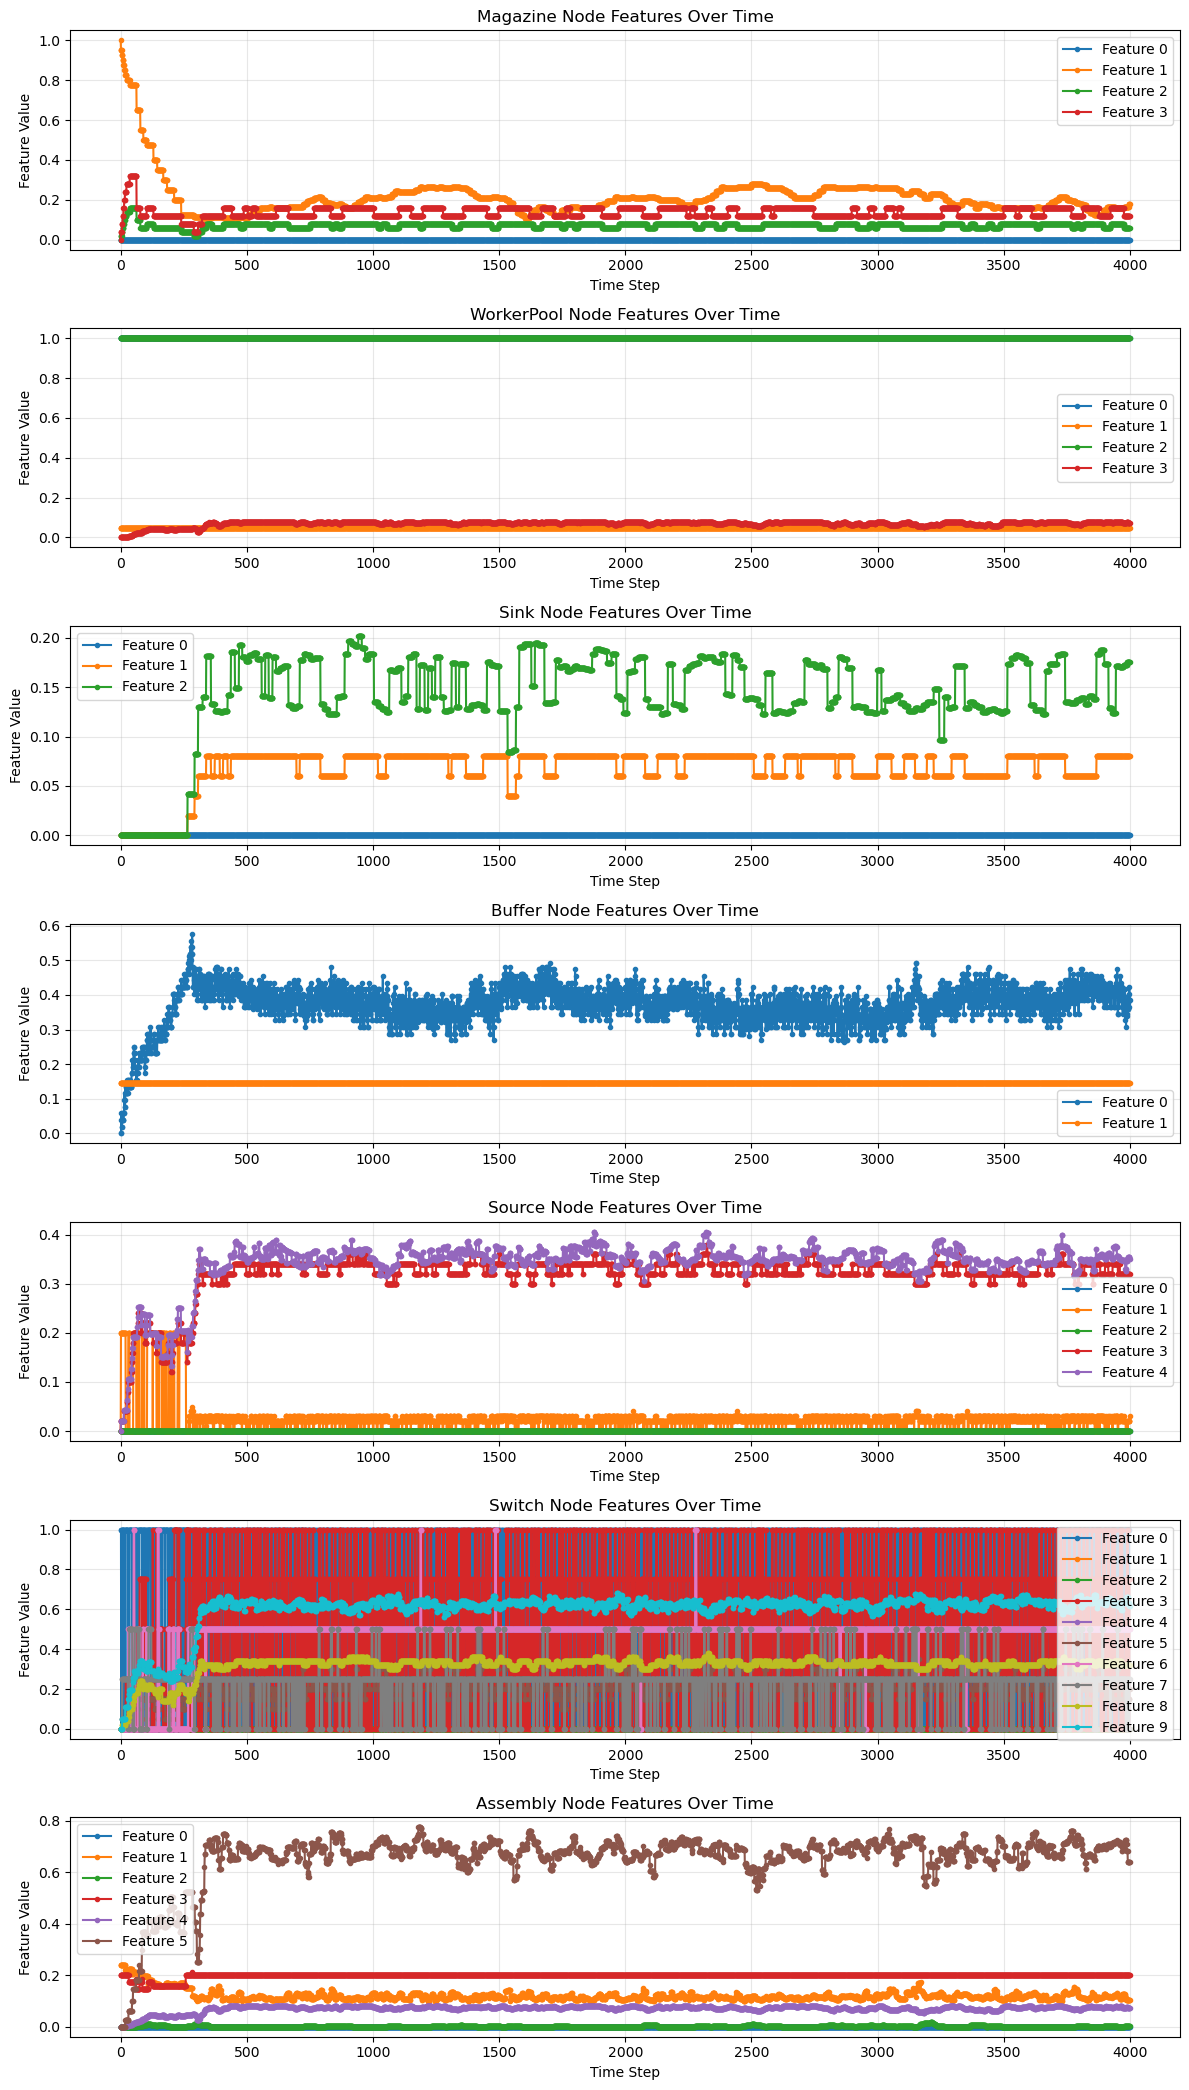

Time series length: 4000 steps
Node types: ['Magazine', 'WorkerPool', 'Sink', 'Buffer', 'Source', 'Switch', 'Assembly']


In [181]:

# Visualize node features across time series
n_graphs = len(dataset['graph'])
node_types = dataset['graph'][0].node_types

# Create a figure with subplots for each node type
fig, axes = plt.subplots(len(node_types), 1, figsize=(12, 3 * len(node_types)))
if len(node_types) == 1:
    axes = [axes]

for i, node_type in enumerate(node_types):
    # Collect features across all time steps
    time_series_features = []
    for t in range(n_graphs):
        features = dataset['graph'][t][node_type].x.numpy()
        time_series_features.append(features)
    
    # Convert to numpy array for easier handling
    time_series_features = np.array(time_series_features)
    
    # If multiple nodes of this type, average across nodes
    if time_series_features.shape[1] > 1:
        # Average across nodes (axis=1) to get mean feature values per timestep
        mean_features = np.mean(time_series_features, axis=1)
    else:
        # Single node, just squeeze the node dimension
        mean_features = time_series_features.squeeze(axis=1)
    
    # Plot each feature dimension over time
    for feature_dim in range(mean_features.shape[1]):
        axes[i].plot(range(n_graphs), mean_features[:, feature_dim], 
                    label=f'Feature {feature_dim}', marker='o', markersize=3)
    
    axes[i].set_title(f'{node_type} Node Features Over Time')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Feature Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Time series length: {n_graphs} steps")
print(f"Node types: {list(node_types)}")

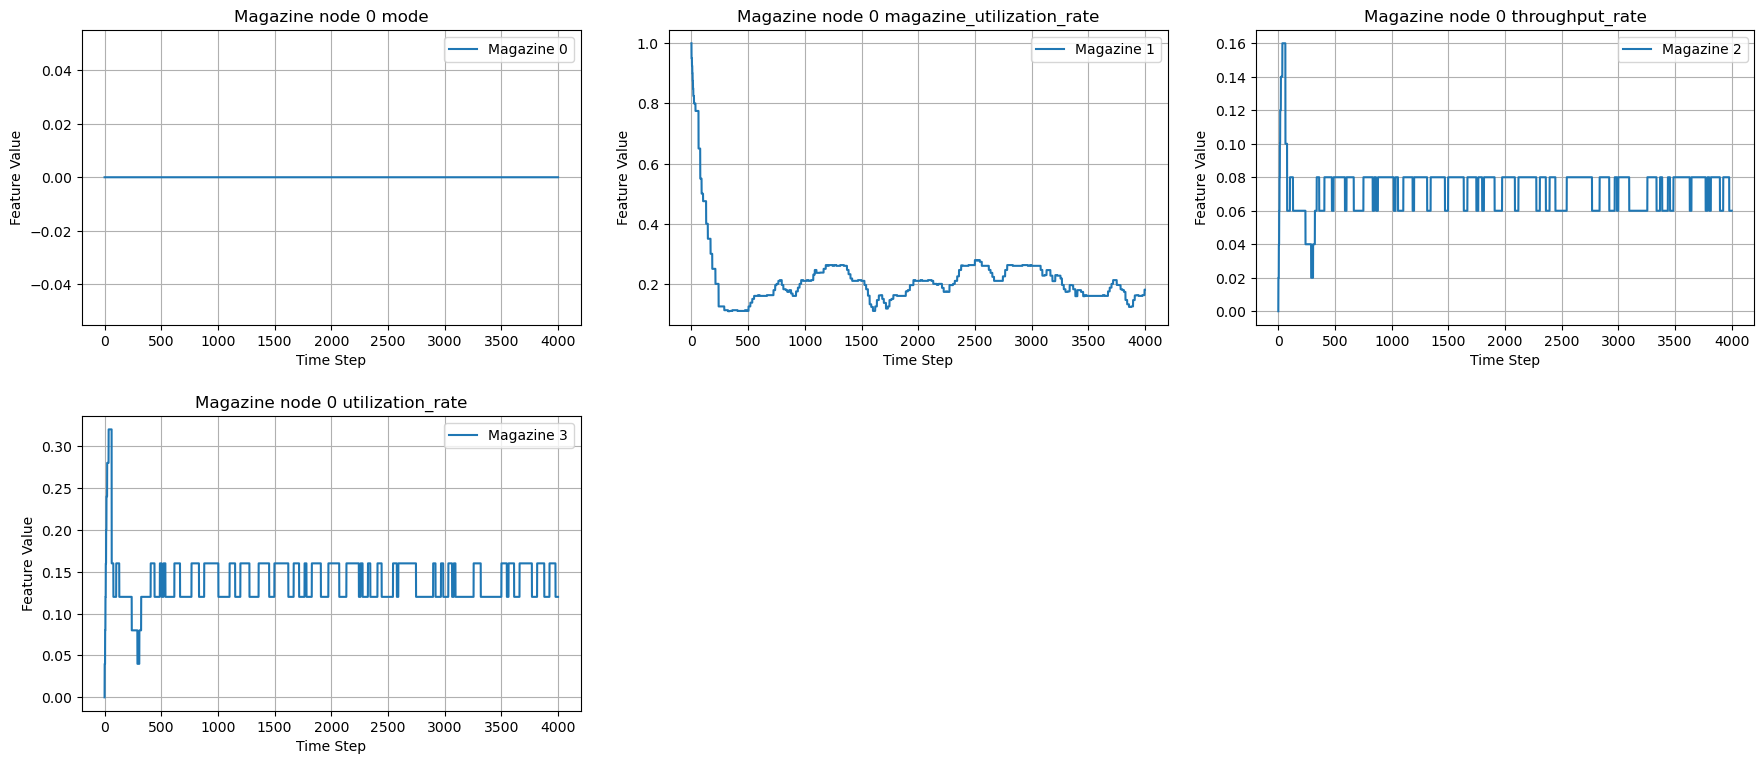

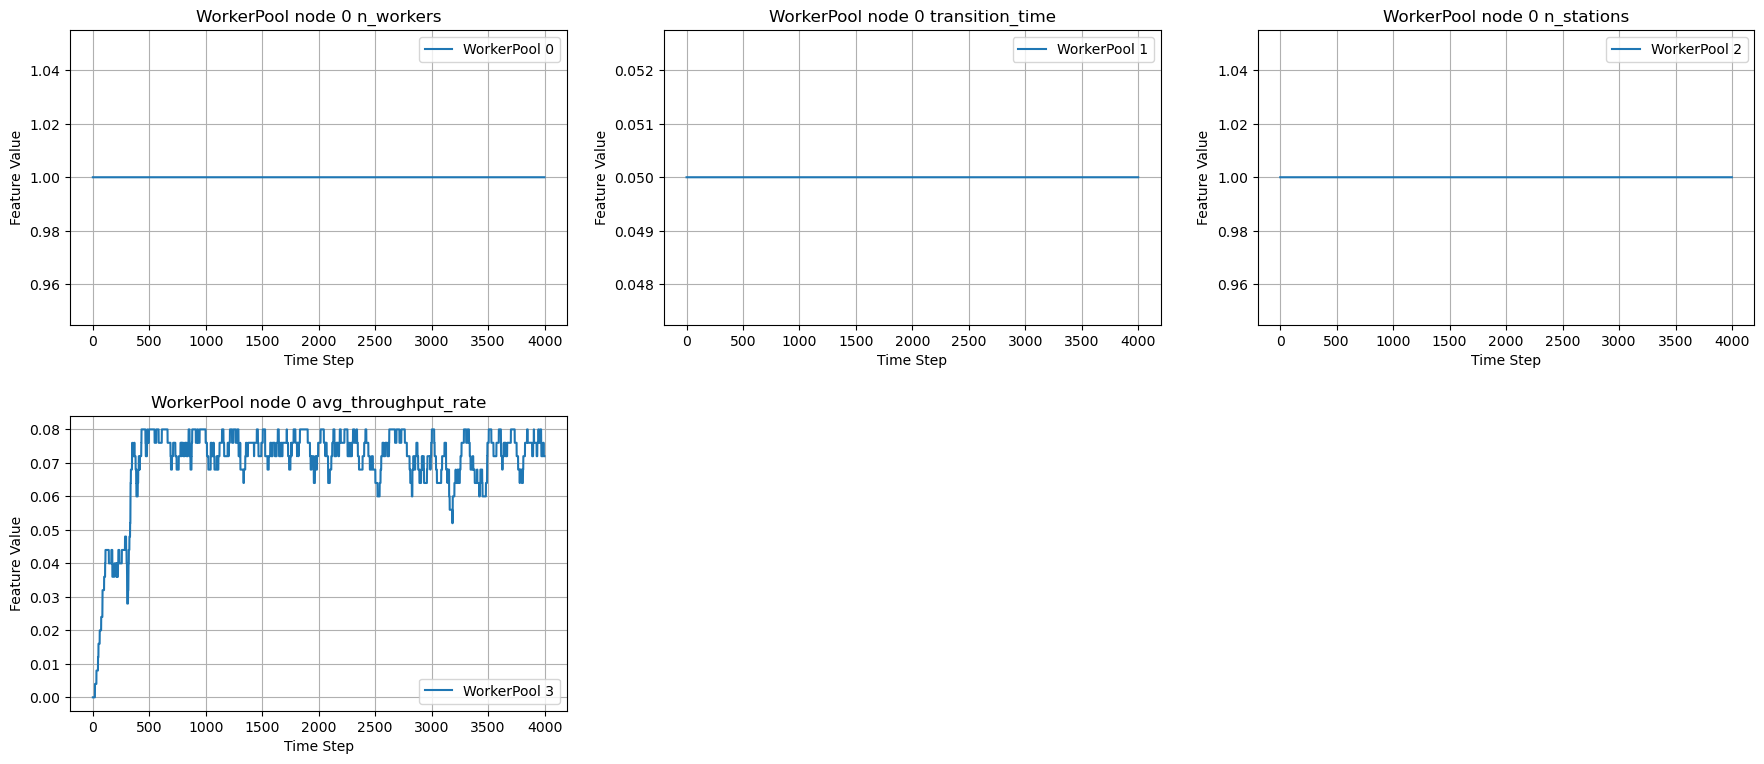

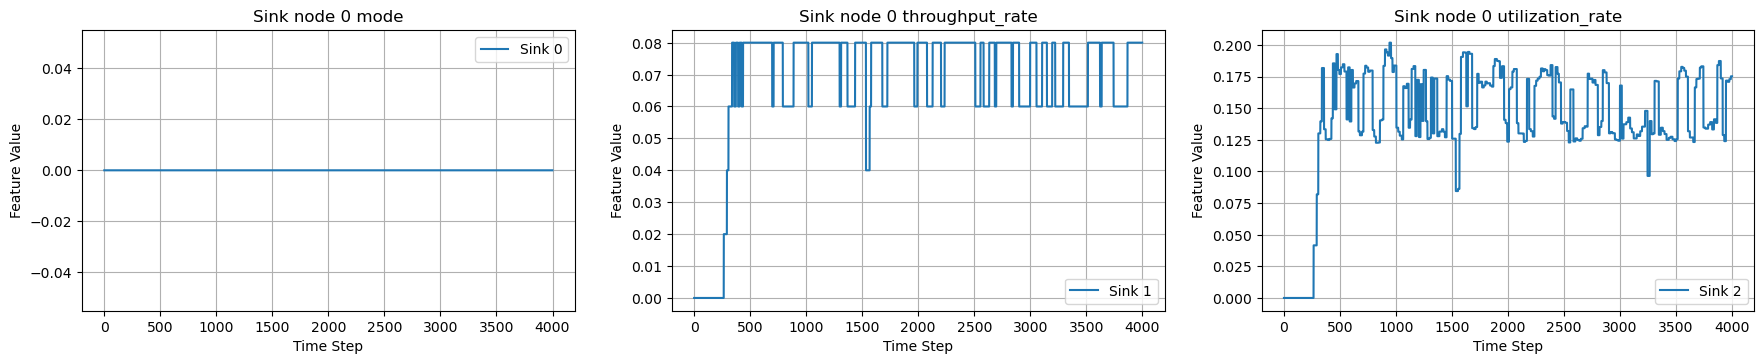

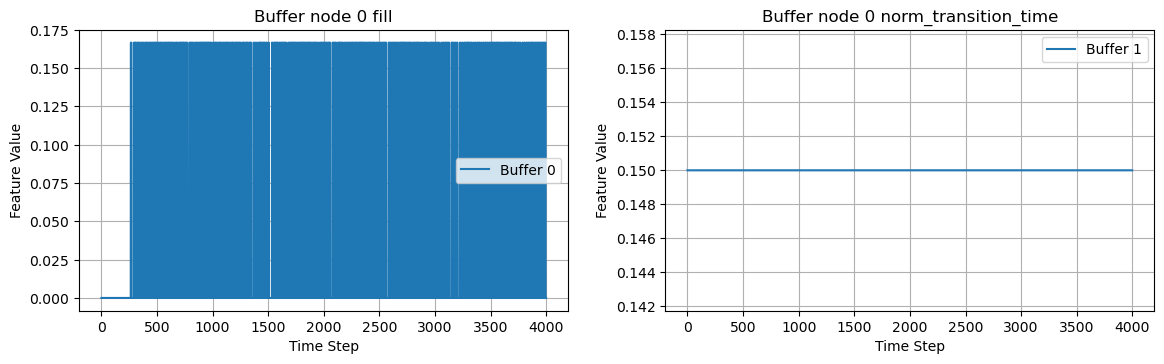

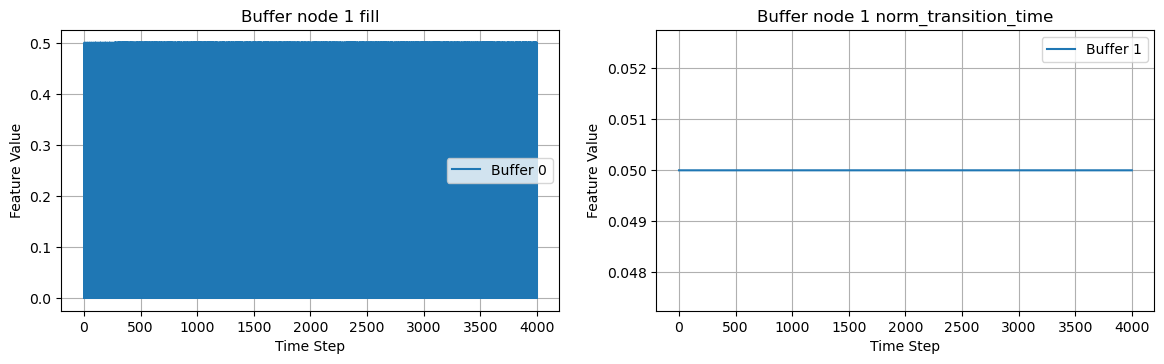

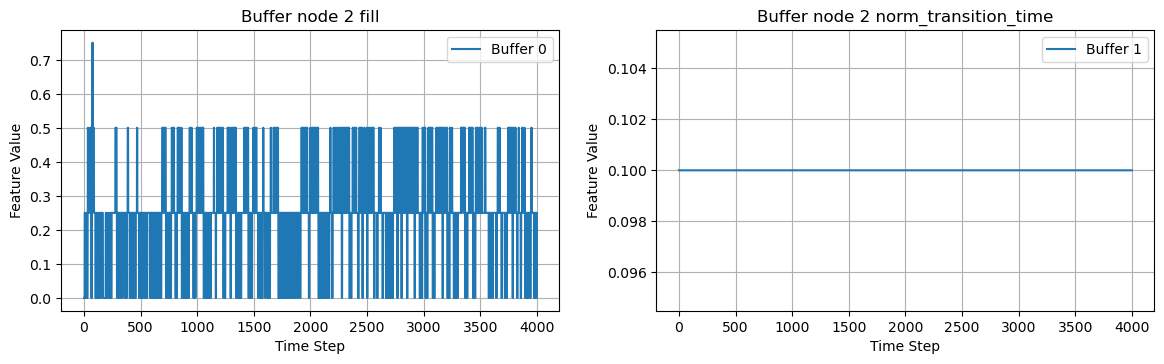

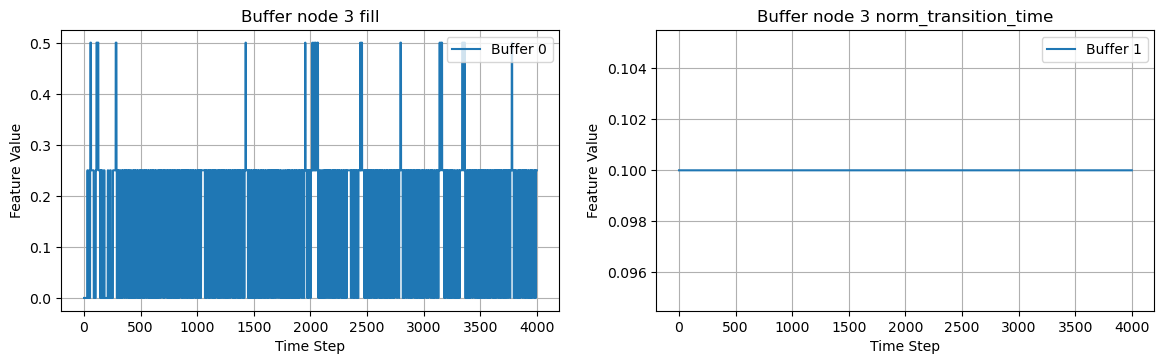

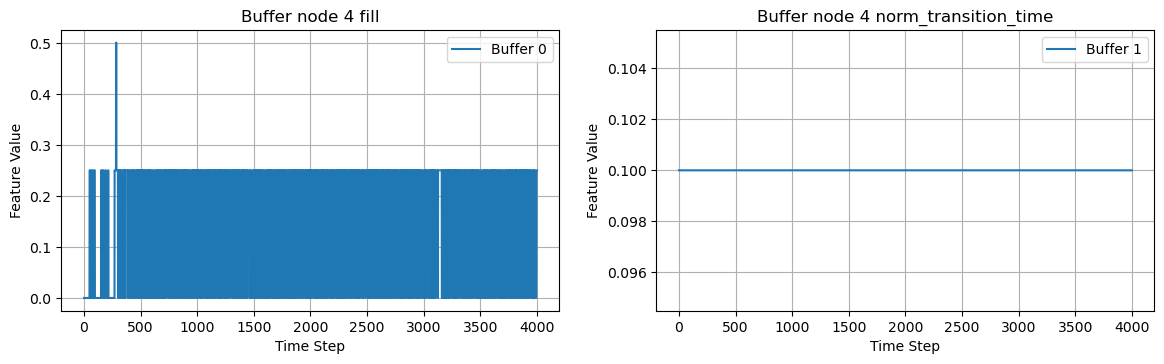

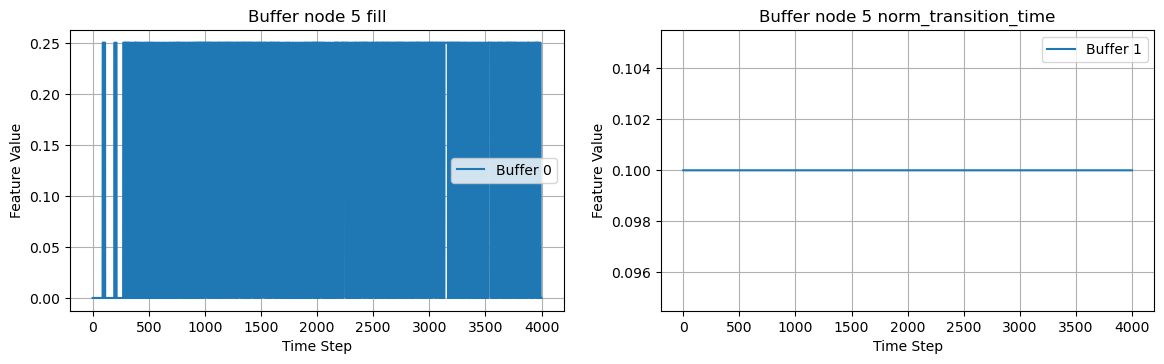

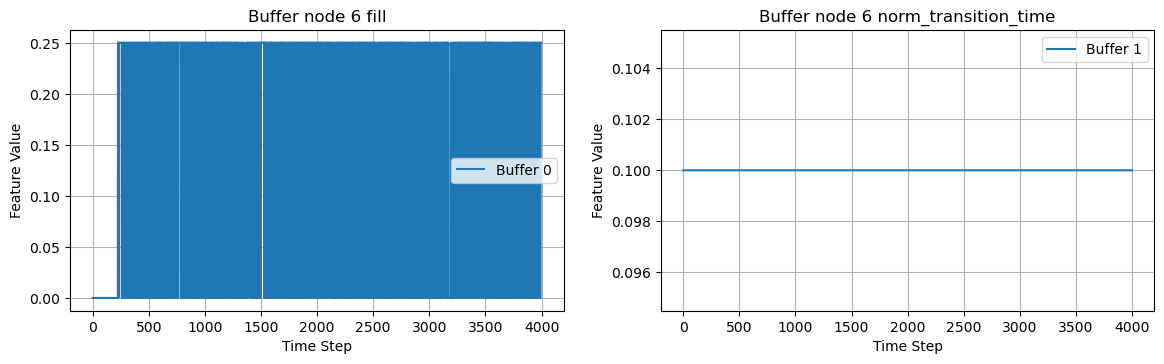

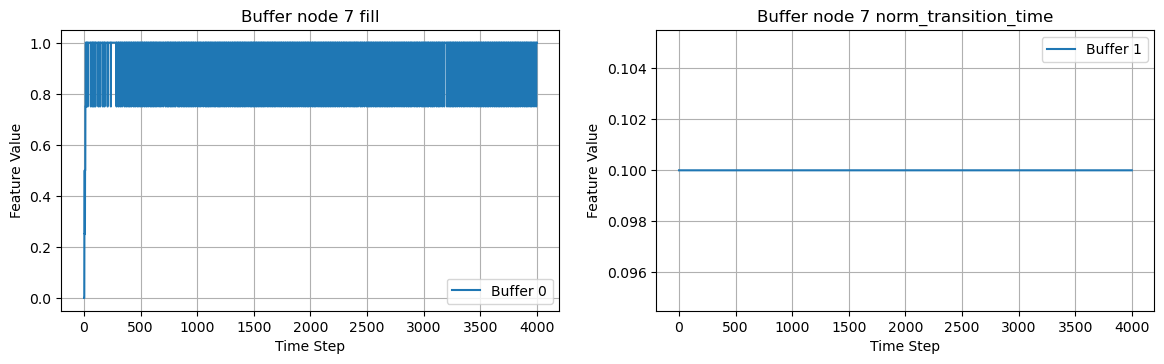

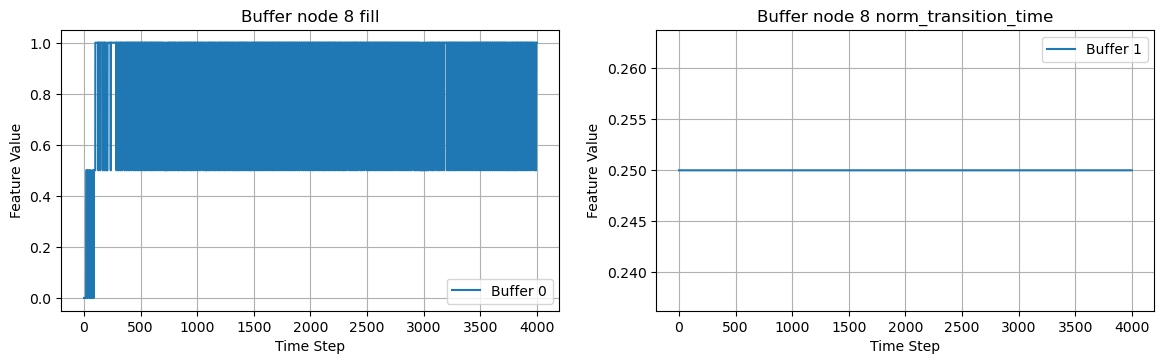

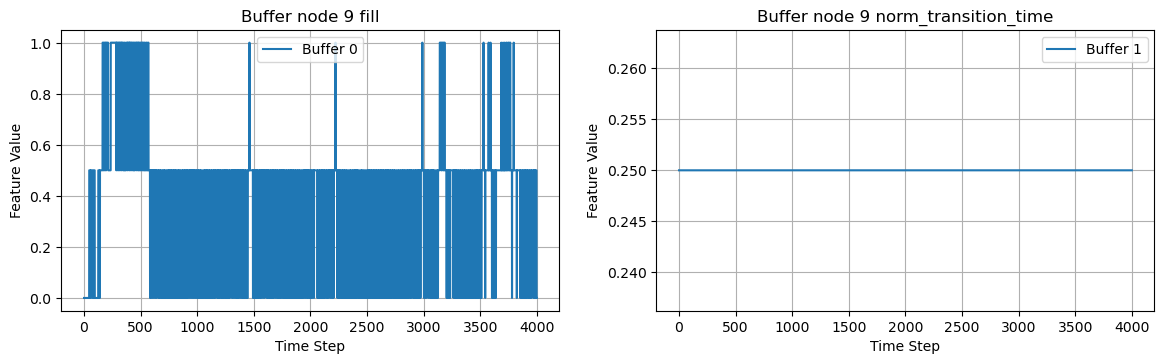

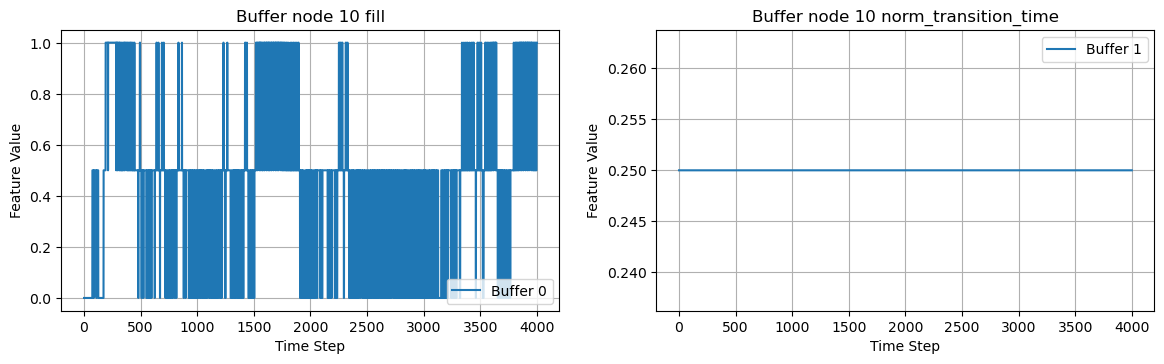

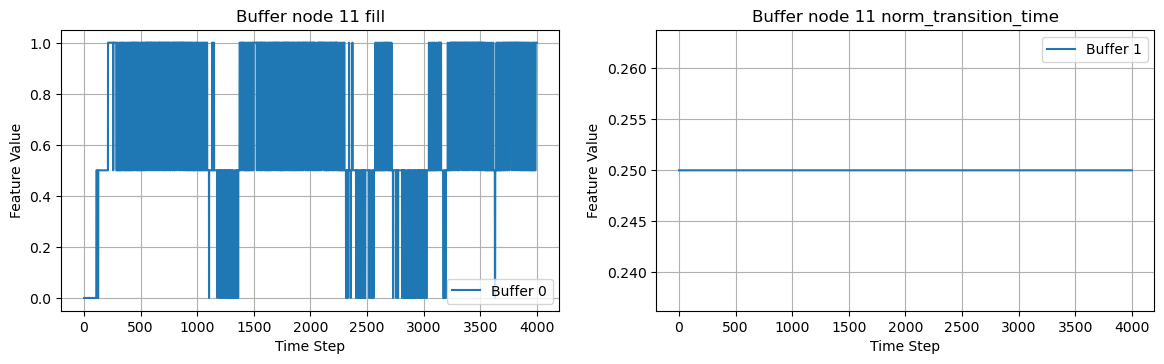

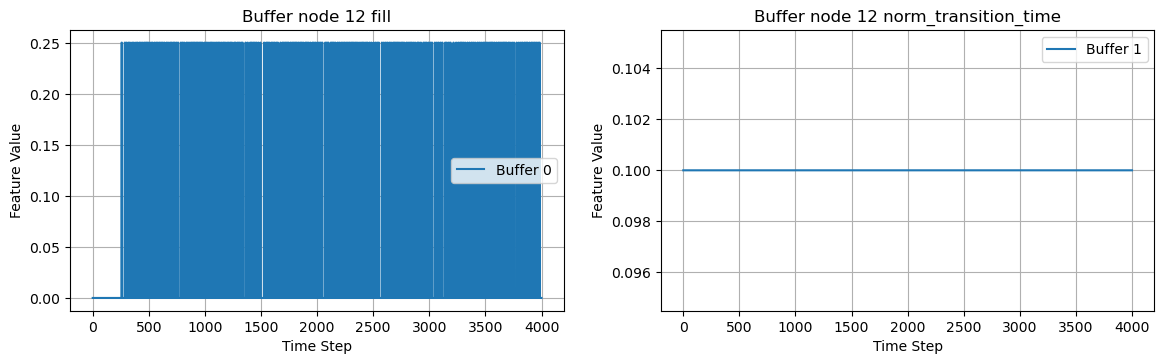

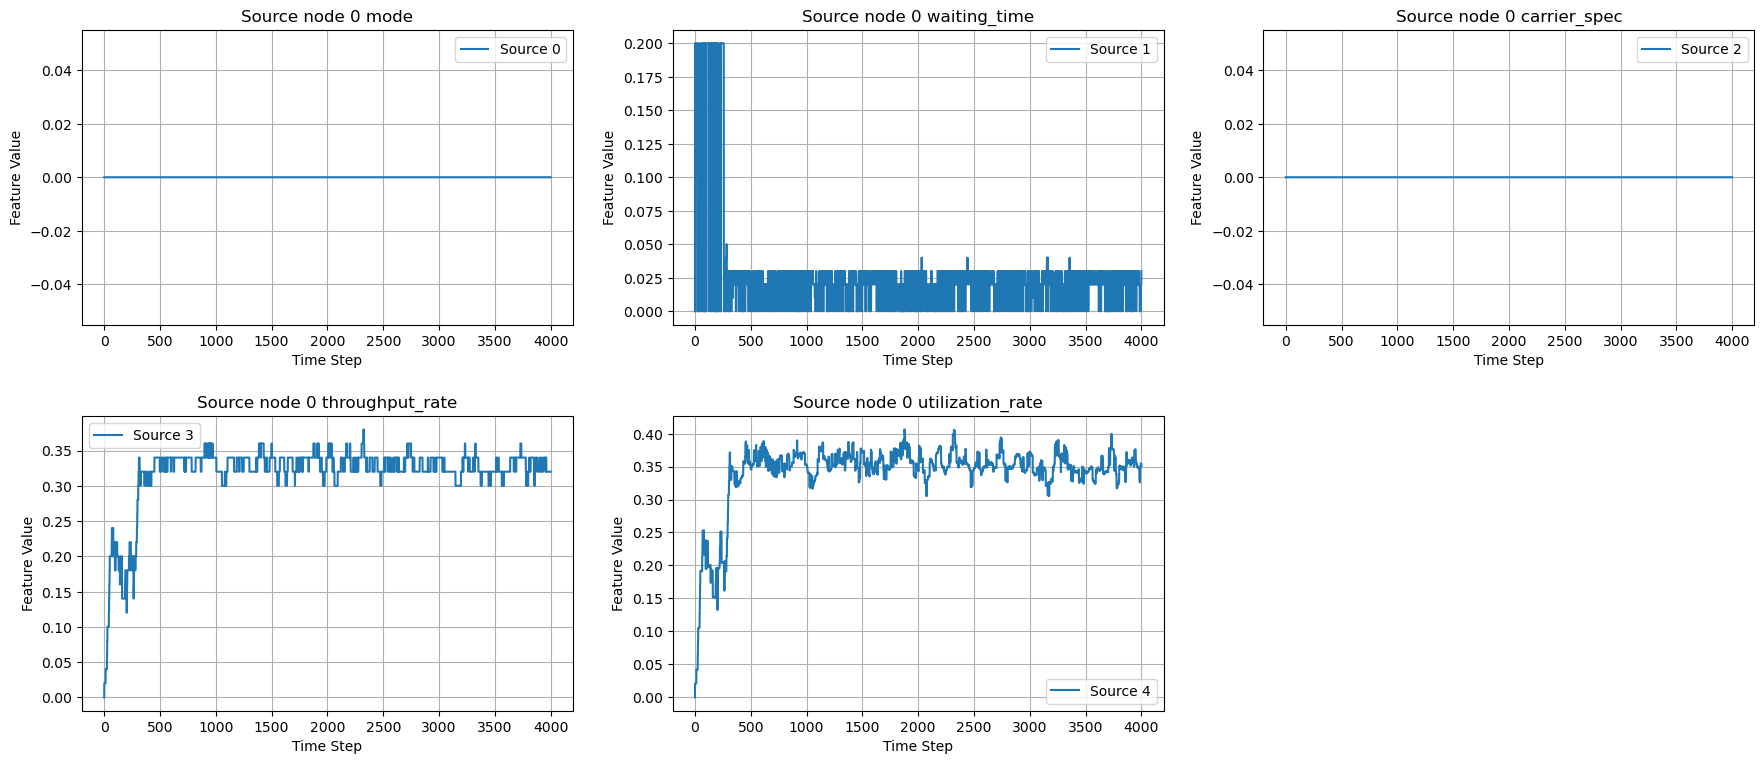

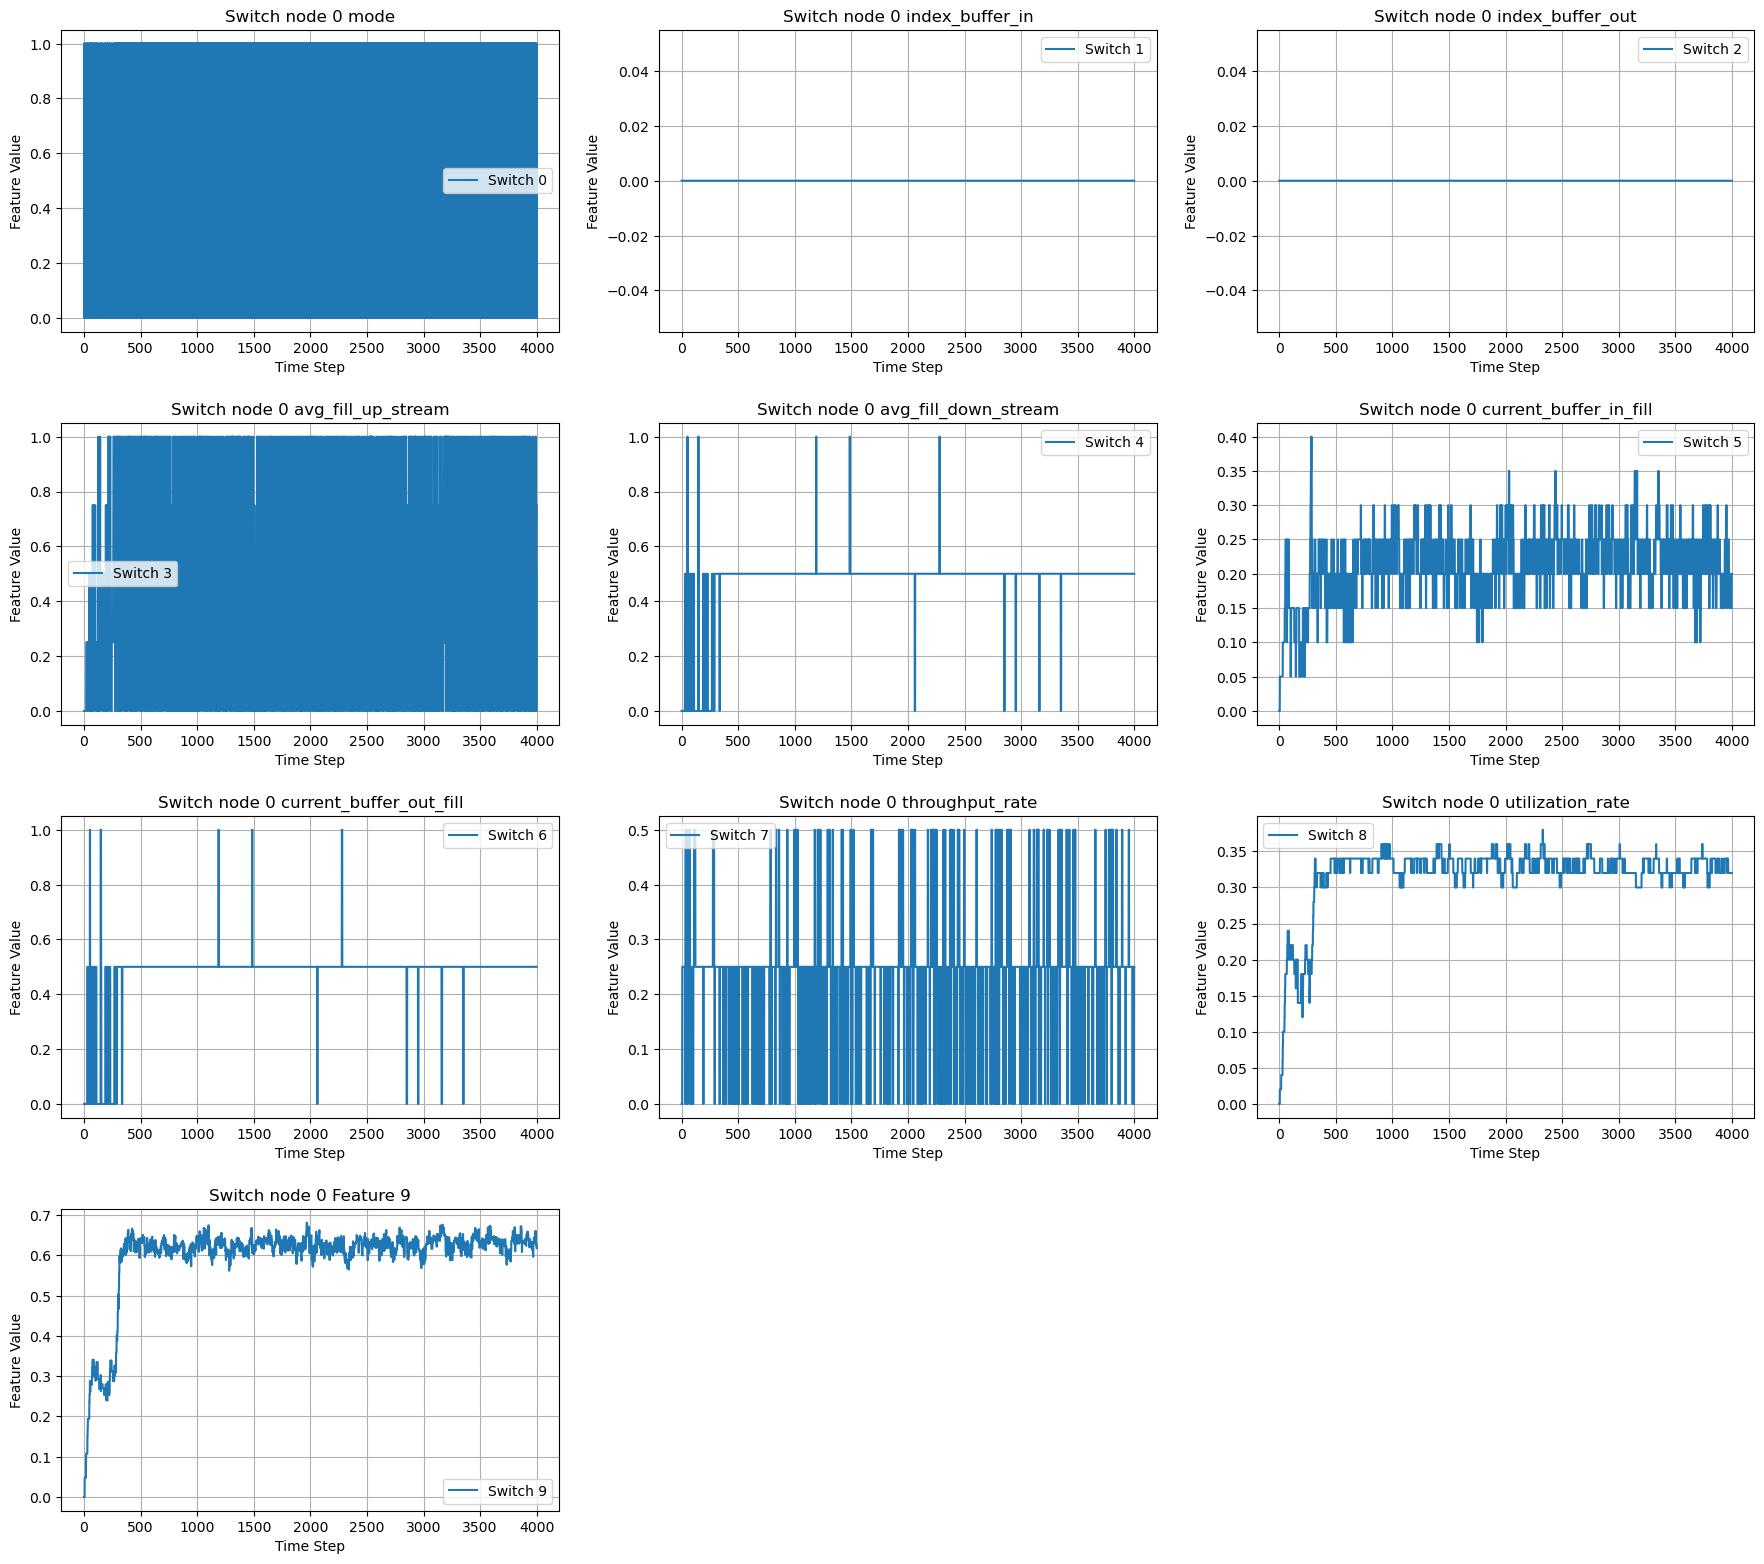

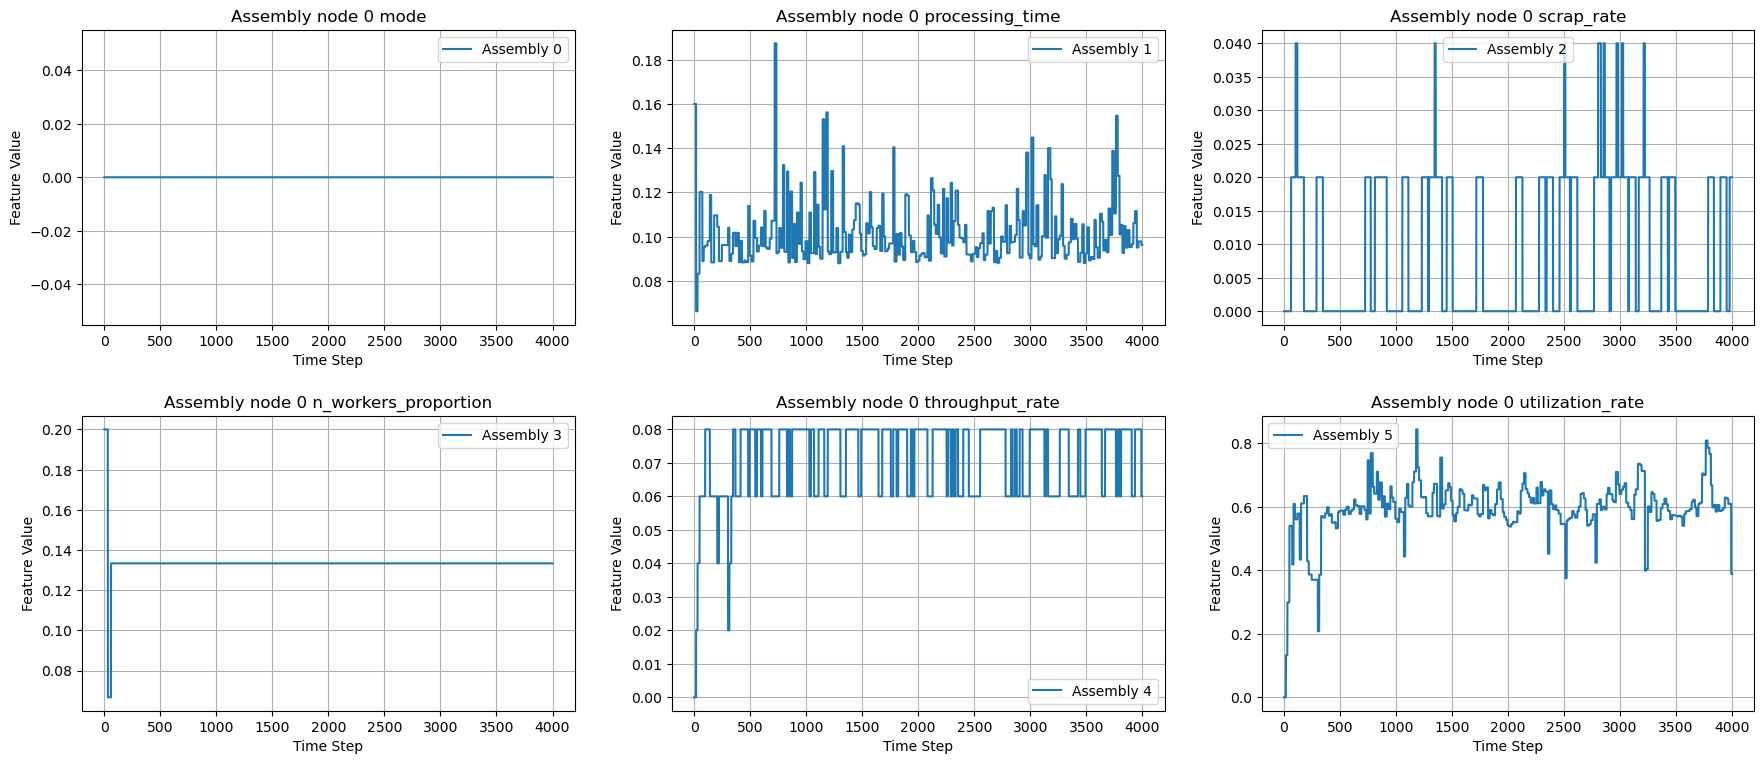

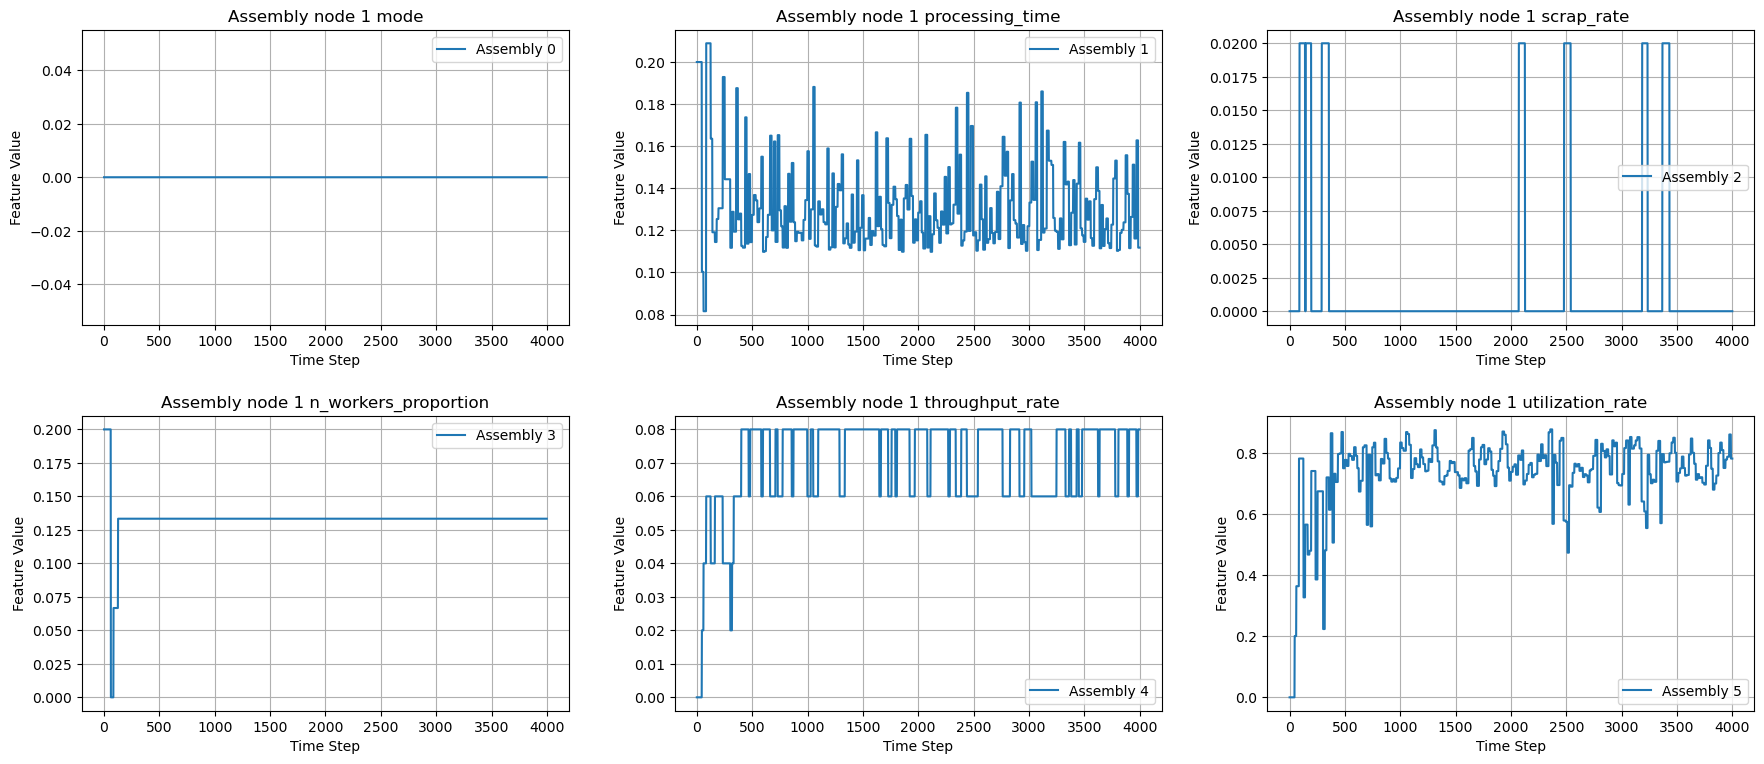

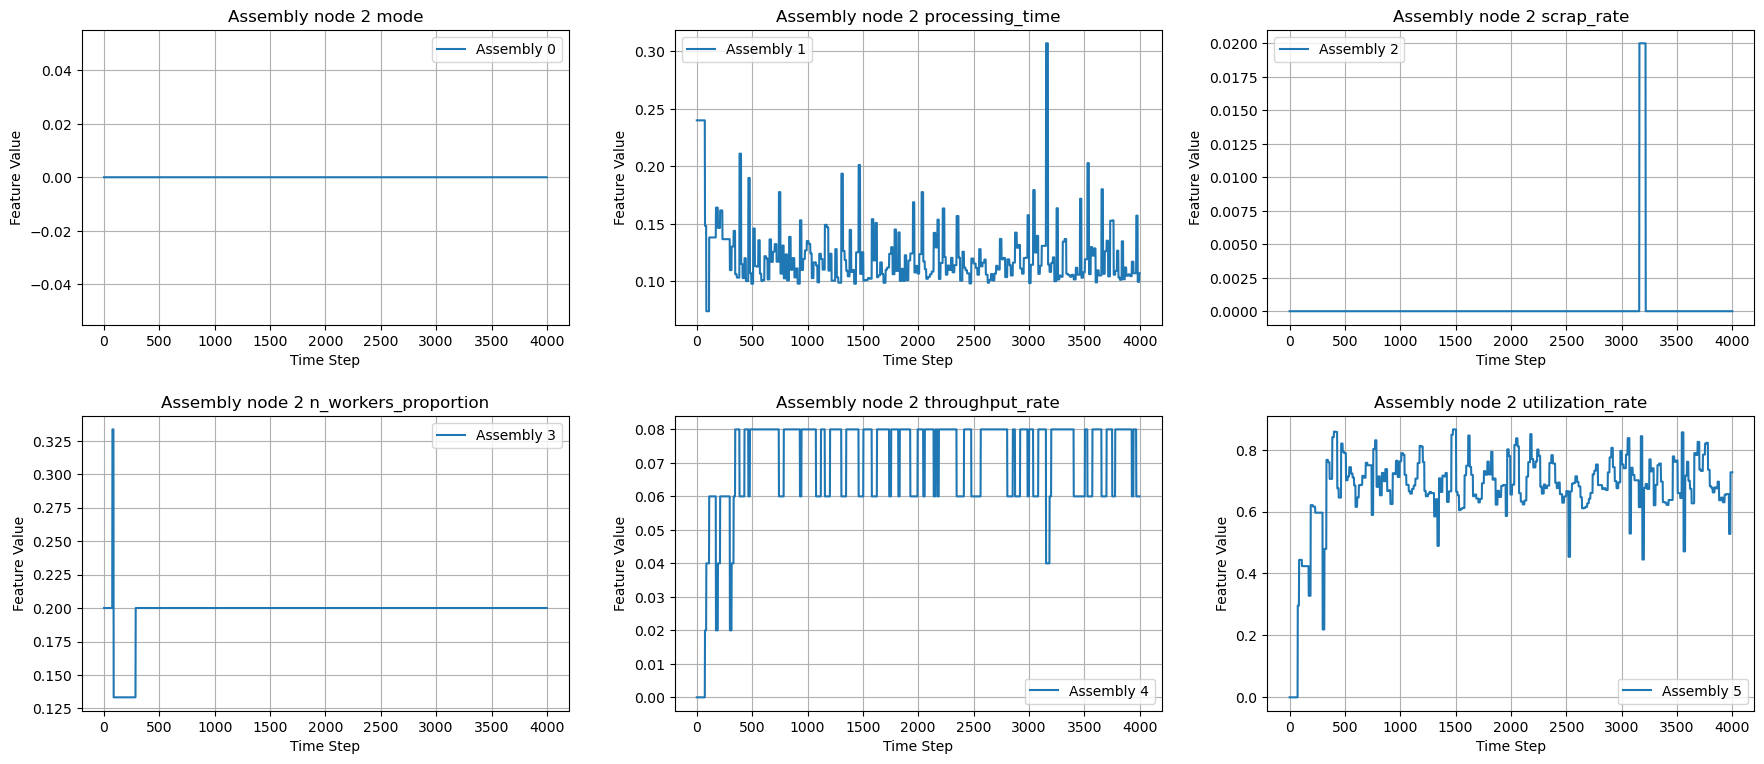

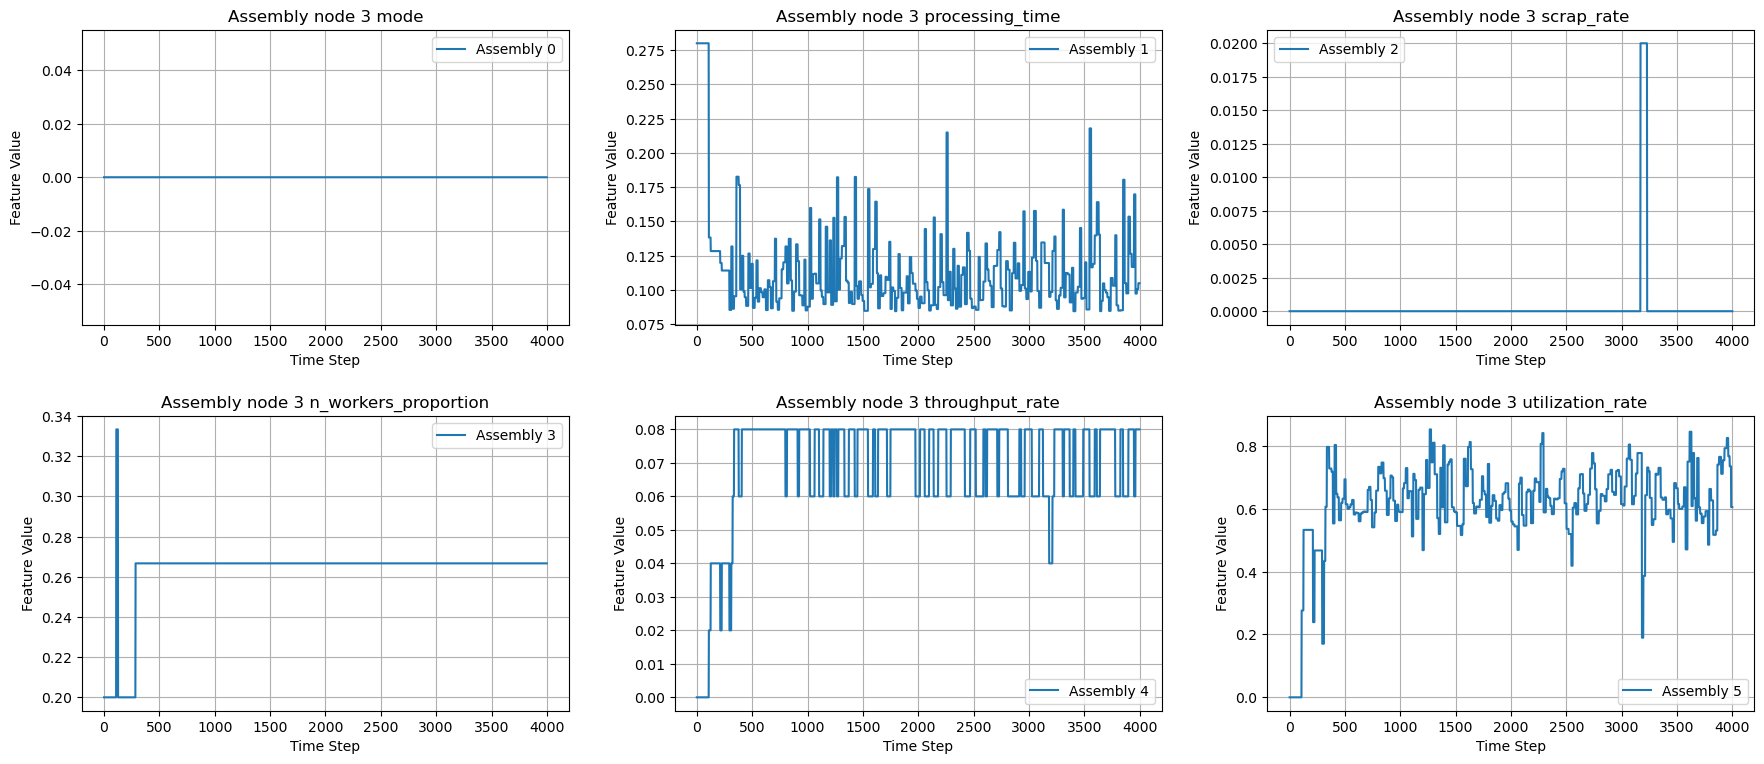

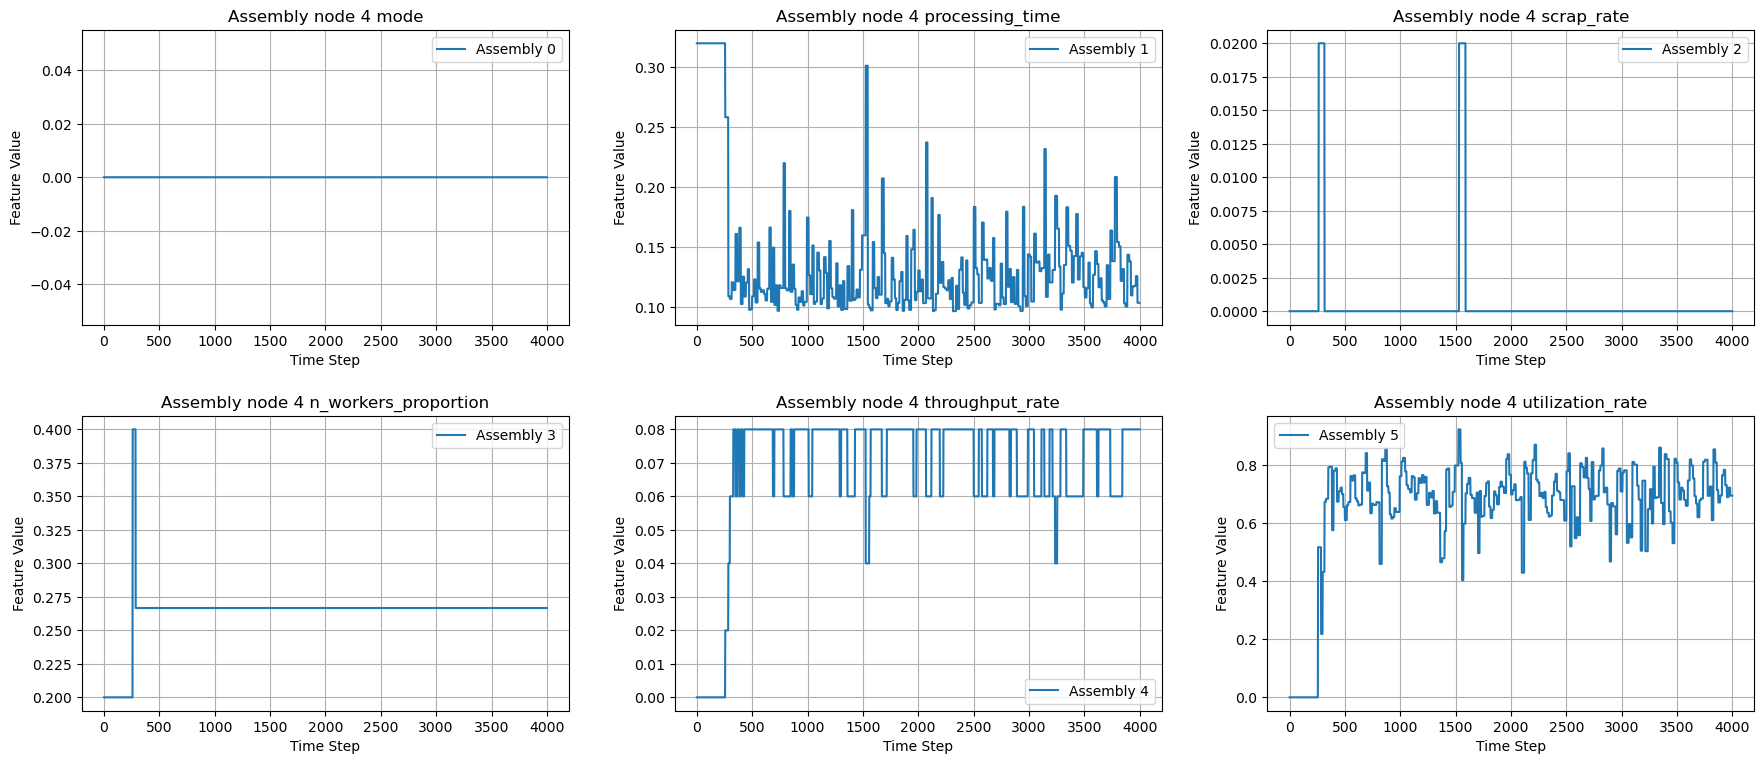

In [182]:
line = ComplexLine(
                realtime=False,
                factor=0.05,
                alternate=False,
                n_assemblies=5,
                n_workers=5*3,
                step_size=1,
                scrap_factor=1/3,
                random_state=0,
                assembly_condition=30,
                use_graph_as_states=True, # test graph,
                use_rates=True
            )
            # Get feature names from the line object
feature_names = {}
for objects in (line.state.object_names):
    obj_name = line._objects[objects].__class__.__name__
    if obj_name not in feature_names:
        feature_name = line._objects[objects].state.names
        obj_observables = line._objects[objects].state.observables
        # Get indices where observables are True
        observable_indices = [i for i, obs in enumerate(obj_observables) if obs]
        # Get the corresponding feature names
        observable_feature_names = [feature_name[i] for i in observable_indices]
        feature_names[obj_name] = observable_feature_names
for current_node_type in dataset['graph'][0].node_types:
    count, dim = dataset['graph'][0][current_node_type].x.shape
    for i in range(count):
        node_data = dataset['graph'][0][current_node_type].x[i]
        node_data = node_data.unsqueeze(0)
        for j in range(1, len(dataset['graph'])):
            node_data = torch.cat((node_data, dataset['graph'][j][current_node_type].x[i].unsqueeze(0)), dim=0)
        # Get the number of features for this node type
        n_features = node_data.shape[1]
        
        # Calculate subplot layout dynamically
        n_cols = min(3, n_features)  # Max 3 columns
        n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
        
        # Handle case where there's only one subplot
        if n_features == 1:
            axs = [axs]
        elif n_rows == 1:
            axs = axs if n_features > 1 else [axs]
        axs = axs.flatten()  # Flatten to make indexing easier
        
        for j in range(node_data.shape[1]):
            axs[j].plot(node_data[:, j].cpu().numpy(), label=f'{current_node_type} {j}')
            feature_name = feature_names[current_node_type][j] if j < len(feature_names[current_node_type]) else f'Feature {j}'
            axs[j].set_title(f'{current_node_type} node {i} {feature_name}')
            axs[j].set_xlabel('Time Step')
            axs[j].set_ylabel('Feature Value')
            axs[j].grid(True)
            axs[j].legend()
        
        # Hide unused subplots
        for k in range(n_features, len(axs)):
            axs[k].axis('off')
        
        plt.tight_layout(pad=2.0)  # Add padding between subplots
        
        plt.show()

## HGNN formulation
The heterogeneous graph neural network part test out if it works if pass through a HeteroData type


In [35]:
sample_graph = dataset['graph'][0]

In [36]:
from typing import Dict, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    HANConv,
    HGTConv,
)
from torch_geometric.nn.dense import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj, EdgeType, Metadata, NodeType


### Standard Heterogeneous graph transformer (HGT)

In [37]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, data):
        super().__init__()

        # project input features to unified hidden dimension
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            in_channels = data.x_dict[node_type].shape[1]
            self.lin_dict[node_type] = Linear(in_channels, hidden_channels)

        # Heterogeneous graph convolution layers
        # pass all the 
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict

In [38]:
test_HGT = HGT(hidden_channels=64, out_channels=32, num_heads=4, num_layers=2, data=sample_graph)

In [40]:
output_HGT =test_HGT(sample_graph.x_dict, sample_graph.edge_index_dict)

In [42]:
output_HGT.keys()

dict_keys(['Magazine', 'WorkerPool', 'Sink', 'Buffer', 'Source', 'Switch', 'Assembly'])

In [50]:
# Stack embeddings from output_HGT

# 1. Concatenate all node embeddings (keeps every node)
all_node_embeddings = torch.cat([output_HGT[k] for k in output_HGT], dim=0)  # [total_nodes, hidden_dim]

# 2. Mean per node type, then stack (fixed size: n_types x hidden_dim)
type_order = sorted(output_HGT.keys())
per_type_mean = torch.stack([output_HGT[k].mean(0) for k in type_order], dim=0)  # [n_types, hidden_dim]

# 3. Single graph embedding
graph_embedding = all_node_embeddings.mean(0)  # [hidden_dim]

print('Type order:', type_order)
print('all_node_embeddings:', all_node_embeddings.shape)
print('per_type_mean:', per_type_mean.shape)
print('graph_embedding:', graph_embedding.shape)

Type order: ['Assembly', 'Buffer', 'Magazine', 'Sink', 'Source', 'Switch', 'WorkerPool']
all_node_embeddings: torch.Size([23, 64])
per_type_mean: torch.Size([7, 64])
graph_embedding: torch.Size([64])


### Standard Heterogeneous graph Attention network (HAN)

In [25]:
class HAN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, data):
        super().__init__()

        # project input features to unified hidden dimension
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            in_channels = data.x_dict[node_type].shape[1]
            self.lin_dict[node_type] = Linear(in_channels, hidden_channels)

        # Heterogeneous graph convolution layers
        # pass all the 
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HANConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict

In [26]:
test_HAN = HAN(hidden_channels=64, out_channels=32, num_heads=4, num_layers=2, data=sample_graph)

In [55]:
HGT_out = test_HGT(sample_graph.x_dict, sample_graph.edge_index_dict)

In [58]:
HGT_out['Switch'].shape

torch.Size([1, 64])

## Test if the Heterogeneous graph transformation to Homogeneous graph is reasonable

In [133]:
sample_graph= dataset['graph'][0]

In [174]:
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv

import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, Linear
from torch_geometric.data import HeteroData

class GATHomo(nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, data: HeteroData):
        super().__init__()

        # projection layers for each node type
        self.lin_dict = nn.ModuleDict()
        for node_type in data.node_types:
            in_channels = data[node_type].x.size(-1)
            self.lin_dict[node_type] = Linear(in_channels, hidden_channels)

        # GAT layers (homogeneous)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            # concat=False keeps feature dim = hidden_channels
            self.convs.append(GATConv(hidden_channels, hidden_channels, heads=num_heads, concat=False))

        self.lin_out = Linear(hidden_channels, out_channels)

    def forward(self, data: HeteroData):
        # project each node type to hidden dim (don’t mutate input)
        for ntype, lin in self.lin_dict.items():
            data[ntype].x = lin(data[ntype].x).relu()

        # flatten hetero -> homo
        homo_data = data.to_homogeneous(add_node_type=True)
        print(homo_data)
        x, edge_index = homo_data.x, homo_data.edge_index

        # run GAT layers
        for conv in self.convs:
            x = conv(x, edge_index).relu()

        out = self.lin_out(x)

        return out, homo_data


In [175]:
test_GAT = GATHomo(hidden_channels=64, out_channels=32, num_heads=4, num_layers=2, data=sample_graph)

In [176]:
GAT_out,x = test_GAT(sample_graph)

Data(edge_index=[2, 63], x=[23, 64], node_type=[23], edge_type=[63])


In [179]:
type(x)

torch_geometric.data.data.Data

In [178]:
GAT_out.shape

torch.Size([23, 32])

In [156]:
x

tensor([[0.0000e+00, 2.9726e-03, 2.5663e-04,  ..., 0.0000e+00, 1.7436e-03,
         1.1738e-03],
        [0.0000e+00, 2.8193e-03, 0.0000e+00,  ..., 0.0000e+00, 1.7317e-03,
         1.8500e-03],
        [0.0000e+00, 3.4429e-03, 0.0000e+00,  ..., 0.0000e+00, 1.4511e-03,
         9.1223e-04],
        ...,
        [5.1255e-05, 2.0547e-03, 0.0000e+00,  ..., 0.0000e+00, 1.6623e-03,
         1.9638e-03],
        [5.1957e-05, 2.0595e-03, 0.0000e+00,  ..., 0.0000e+00, 1.6612e-03,
         1.9622e-03],
        [0.0000e+00, 2.3997e-03, 0.0000e+00,  ..., 0.0000e+00, 1.5091e-03,
         1.8701e-03]], grad_fn=<ReluBackward0>)

## Stablebaselines training script

- use custom features extracter containing the GNN for the PPO training

In [28]:
import wandb
import ast
import argparse
import os
from lineflow.helpers import get_device
from lineflow.learning.helpers import (
    make_stacked_vec_env,
)
from lineflow.learning.curriculum import CurriculumLearningCallback
from lineflow.examples import (
    MultiProcess,
    WorkerAssignment,
    ComplexLine,
    WaitingTime,
    WaterLine,
)
from sb3_contrib import (
    RecurrentPPO,
    TRPO,
)
from stable_baselines3.common.callbacks import (
    CallbackList,
    EvalCallback,
)
from stable_baselines3 import (
    PPO,
    A2C,
)

from wandb.integration.sb3 import WandbCallback
import torch
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import PPO
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv
import gymnasium as gym
from gymnasium import spaces

### make the line object for the gym environment to work in

In [29]:
def _make_line(name, n_cells, info, simulation_step_size=1, curriculum=False):

    if name == 'part_distribution':
        return MultiProcess(
            alternate=False,
            n_processes=n_cells,
            step_size=simulation_step_size,
            info=info,
        )

    if name == 'worker_assignment':
        return WorkerAssignment(
            n_assemblies=n_cells,
            with_rework=False,
            step_size=simulation_step_size,
            info=info,
        )

    if name == 'complex_line':
        return ComplexLine(
            alternate=False,
            n_assemblies=n_cells,
            n_workers=3*n_cells,
            scrap_factor=0 if curriculum else 1/n_cells,
            step_size=simulation_step_size,
            info=info,
            )

    if name == 'waiting_time':
        return WaitingTime(
            step_size=simulation_step_size,
            info=info,
            processing_time_source=5, 
        )

    if name == 'waiting_time_jump':
        return WaitingTime(
            step_size=simulation_step_size,
            info=info,
            processing_time_source=5, 
            with_jump=True, 
            t_jump_max=2000, 
            scrap_factor=1,
        )
    if name == 'water_line':
        return WaterLine(
            info=info,
            step_size=simulation_step_size,
            scrap_factor=1
            # use_graph_as_states=False,
            # scrap_factor=0 if curriculum else 1/n_cells,
        )
    raise ValueError('Unkown simulation')

In [ ]:
test_config = {
    'env': "worker_assignment",
    'n_cells': 3,
    'model': "PPO",
    'learning_rate': 0.0003,
    'ent_coef': 0.1,
    'n_stack': 1,
    'n_steps': 500,  # Time until update is done
    'n_envs': 1,
    'seed': 0,
    'total_steps': 500_000,
    'log_dir': "./logs",  # Location where tensorboard logs are saved
    'simulation_end': 4000,  # Time of simulation, an update is done after every simulation
    'gamma': 0.99,
    'clip_range': 0.2,
    'max_grad_norm': 0.5,
    'normalize_advantage': False,
    'recurrent': False,
    'deterministic': False,
    'curriculum': False,
    'info': [],  # Station info that should be logged like [('A1', 'waiting_time')]
    'eval_reward': "parts",
    'rollout_reward': "parts",
    'simulation_step_size': 2,
}

In [32]:
test_env = make_stacked_vec_env(
        line=_make_line(test_config['env'], test_config['n_cells'], test_config['info'], curriculum=test_config['curriculum']),
        simulation_end=test_config['simulation_end'],
        reward=test_config["rollout_reward"],
        n_envs=1,
        n_stack=test_config['n_stack'] if not test_config['recurrent'] else 1,
    )

### Base features extractor class to take in the Dict type from the line

In [57]:
class HeteroGraphFeatureExtractor_test(BaseFeaturesExtractor):
    def __init__(self, 
                 observation_space: spaces.Dict,
                 data: HeteroData,
                 hidden_channels: int = 64, 
                 out_channels: int = 64, 
                 num_heads: int = 4, 
                 num_layers: int = 2, 
                 ):
        # TODO: add calculations for the features_dim before the calling the super().__init__
        # the aggregation of the feature dim used for the policy and value function can be the following possibilities
        # 1. stack of all of the features and then pass it through the mlp for the policy
        # 2. use the relevant node and edge features for the task and available action spaces
        # 3. use pooling for each of the node and edge features
        # self.features_dim = out_channels * num_heads
        self.features_dim = 64
        super().__init__(observation_space, self.features_dim)
        """
        Initialize the HeteroGraphFeatureExtractor.

        Args:
            observation_space (spaces.Dict): The observation space.
            data (HeteroData): The heterogeneous graph data.
            features_dim (int, optional): The dimension of the input features for policy and value function.
            hidden_channels (int, optional): The number of hidden channels for the GNN.
            out_channels (int, optional): The number of output channels.
            num_heads (int, optional): The number of attention heads.
            num_layers (int, optional): The number of layers.
        """
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.data = data
        self.HGT_model = HGT(hidden_channels, out_channels, num_heads, num_layers, data)
        

        # Final aggregation to fixed size then pass it through the mlp for the policy
        self.final_projection = nn.Linear(self.hidden_channels, self.features_dim)
    
    # convert from dictionary back to hetero_graph
    def _convert_dict_to_hetero_graph(obs_dict):
        """
        Convert dictionary format observation back to HeteroData object
        
        Args:
            obs_dict: Dictionary with node and edge information in the format:
                    - "{node_type}_x": node features (numpy array)
                    - "edge_index_{src}_{rel}_{dst}": edge indices (numpy array)
                    - "edge_attr_{src}_{rel}_{dst}": edge attributes (numpy array)
            
        Returns:
            HeteroData: PyTorch Geometric heterogeneous graph
        """
        hetero_data = HeteroData()
        
        # Extract node features, edge indices, and edge attributes
        node_features = {}
        edge_indices = {}
        edge_attributes = {}
        
        for key, value in obs_dict.items():
            if key.endswith('_x'):
                # This is node feature data
                node_type = key[:-2]  # Remove '_x' suffix
                
                # Convert to tensor if needed
                if not isinstance(value, torch.Tensor):
                    value = torch.tensor(value, dtype=torch.float32)
                
                node_features[node_type] = value
                
            elif key.startswith('edge_index_'):
                # This is edge index data
                # Parse edge type from key: "edge_index_{src}_{rel}_{dst}"
                parts = key.split('_')[2:]  # Remove 'edge_index_' prefix
                
                if len(parts) >= 3:
                    src_type = parts[0]
                    rel_type = parts[1] 
                    dst_type = parts[2]
                    edge_type = (src_type, rel_type, dst_type)
                else:
                    # Fallback for simpler edge naming
                    edge_type = tuple(parts)
                
                # Convert to tensor if needed
                if not isinstance(value, torch.Tensor):
                    value = torch.tensor(value, dtype=torch.long)
                
                edge_indices[edge_type] = value
                
            elif key.startswith('edge_attr_'):
                # This is edge attribute data
                # Parse edge type from key: "edge_attr_{src}_{rel}_{dst}"
                parts = key.split('_')[2:]  # Remove 'edge_attr_' prefix
                
                if len(parts) >= 3:
                    src_type = parts[0]
                    rel_type = parts[1] 
                    dst_type = parts[2]
                    edge_type = (src_type, rel_type, dst_type)
                else:
                    # Fallback for simpler edge naming
                    edge_type = tuple(parts)
                
                # Convert to tensor if needed
                if not isinstance(value, torch.Tensor):
                    value = torch.tensor(value, dtype=torch.float32)
                
                edge_attributes[edge_type] = value
        
        # Add node features to HeteroData
        for node_type, features in node_features.items():
            hetero_data[node_type].x = features
        
        # Add edge indices to HeteroData
        for edge_type, edge_index in edge_indices.items():
            hetero_data[edge_type].edge_index = edge_index
        
        # Add edge attributes to HeteroData
        for edge_type, edge_attr in edge_attributes.items():
            hetero_data[edge_type].edge_attr = edge_attr
        
        return hetero_data

    # convert from hetero_graph to dictionary
    def _convert_hetero_graph_to_dict(hetero_data):
        """
        Convert HeteroData back to dictionary format compatible with gymnasium spaces.Dict
        
        Args:
            hetero_data: HeteroData object
            
        Returns:
            dict: Dictionary with node and edge information compatible with spaces.Dict
        """
        obs_dict = {}
        
        # Convert node features to dictionary format
        for node_type in hetero_data.node_types:
            if node_type in hetero_data.x_dict:
                node_features = hetero_data.x_dict[node_type]
                if isinstance(node_features, torch.Tensor):
                    node_features = node_features.detach().cpu().numpy()
                
                # Ensure consistent dtype and shape
                node_features = np.asarray(node_features, dtype=np.float32)
                obs_dict[f"{node_type}_x"] = node_features
        
        # Convert edge indices and edge attributes to dictionary format  
        for edge_type in hetero_data.edge_types:
            edge_type_str = f"{edge_type[0]}_{edge_type[1]}_{edge_type[2]}"
            
            # Handle edge indices
            if edge_type in hetero_data.edge_index_dict:
                edge_index = hetero_data.edge_index_dict[edge_type]
                if isinstance(edge_index, torch.Tensor):
                    edge_index = edge_index.detach().cpu().numpy()
                
                # Ensure consistent dtype for edge indices
                edge_index = np.asarray(edge_index, dtype=np.int64)
                obs_dict[f"edge_index_{edge_type_str}"] = edge_index
            
            # Handle edge attributes
            if hasattr(hetero_data[edge_type], 'edge_attr') and hetero_data[edge_type].edge_attr is not None:
                edge_attr = hetero_data[edge_type].edge_attr
                if isinstance(edge_attr, torch.Tensor):
                    edge_attr = edge_attr.detach().cpu().numpy()
                
                # Ensure consistent dtype for edge attributes
                edge_attr = np.asarray(edge_attr, dtype=np.float32)
                obs_dict[f"edge_attr_{edge_type_str}"] = edge_attr
        
        return obs_dict

    # build the observation space needed for the gym API
    def _build_observation_space_hetero_graph(sample_graph=None):
        """
        Build observation space for heterogeneous graphs compatible with gymnasium spaces.Dict
        
        Args:
            line_state: Line state object (optional)
            sample_graph: Sample HeteroData object to infer shapes
            
        Returns:
            spaces.Dict: Observation space compatible with gymnasium
        """
        
        # Create observation space based on HeteroData structure
        space_dict = {}
        
        # For each node type in the heterogeneous graph
        for node_type in sample_graph.node_types:
            if node_type in sample_graph.x_dict:
                node_features = sample_graph.x_dict[node_type]
                if isinstance(node_features, torch.Tensor):
                    shape = tuple(node_features.shape)
                else:
                    shape = tuple(np.array(node_features).shape)
                
                # Create Box space for node features
                space_dict[f"{node_type}_x"] = spaces.Box(
                    low=0,
                    high=1,
                    shape=shape,
                    dtype=np.float32
                )
        
        # Add edge information (indices and attributes)
        for edge_type in sample_graph.edge_types:
            edge_type_str = f"{edge_type[0]}_{edge_type[1]}_{edge_type[2]}"
            
            # Edge indices
            if edge_type in sample_graph.edge_index_dict:
                edge_index = sample_graph.edge_index_dict[edge_type]
                if isinstance(edge_index, torch.Tensor):
                    shape = tuple(edge_index.shape)
                else:
                    shape = tuple(np.array(edge_index).shape)
                
                space_dict[f"edge_index_{edge_type_str}"] = spaces.Box(
                    low=0,
                    high=1,  # Use proper max for int64
                    shape=shape,
                    dtype=np.float32
                )
            
            # Edge attributes
            if hasattr(sample_graph[edge_type], 'edge_attr') and sample_graph[edge_type].edge_attr is not None:
                edge_attr = sample_graph[edge_type].edge_attr
                if isinstance(edge_attr, torch.Tensor):
                    shape = tuple(edge_attr.shape)
                else:
                    shape = tuple(np.array(edge_attr).shape)
                
                space_dict[f"edge_attr_{edge_type_str}"] = spaces.Box(
                    low=0,
                    high=1,
                    shape=shape,
                    dtype=np.float32
                )
        
        return spaces.Dict(space_dict)
    
    def forward(self, observations: Dict[str, torch.Tensor]) -> torch.Tensor:
        ## convert Dict to HeteroData
        graph_data = _convert_dict_to_hetero_graph(observations)

        graph_dict = self.HGT_model(graph_data)

        feature_for_policy = graph_dict['node_features']
        # Pass through MLP
        return self.final_projection(feature_for_policy)


In [63]:
test_env.observation_space

Box(0.0, [[  2.  inf   2.   2.   2.   2.   2.   2.   2.   2.   2.  inf  inf  inf
    2.   1.   1.   2.  inf  inf  inf   2. 199.   0.   1.   1.   2.  inf
   inf  inf   2. 199.   0.   1.   1.   2.  inf  inf  inf   2. 199.   0.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]], (1, 52), float32)

In [ ]:
test_feature_extraction = HeteroGraphFeatureExtractor_test(observation_space=test_env.observation_space, )


TypeError: __init__() missing 2 required positional arguments: 'observation_space' and 'data'

### Full training code

In [59]:
def train(config):
    """
    Function that handles RL training

    Args:
    - `train`: Scores from the model update phase
    - `rollout`: Scores when a policy is rolled out to gather new experiences.
    - `eval`: Scores when a policy is evaluated on a separate environment

    Notes:
        Size of rollout-buffer: `n_steps*n_envs`, then an model-update is done
    """

    simulation_end = config['simulation_end'] + 1

    env_train = make_stacked_vec_env(
        line=_make_line(config['env'], config['n_cells'], config['info'], curriculum=config['curriculum'], use_graph_as_states=config['use_graph_as_states']),
        simulation_end=simulation_end,
        reward=config["rollout_reward"],
        n_envs=1,
        use_graph_as_states=config['use_graph_as_states'],
        n_stack=config['n_stack'] if not config['recurrent'] else 1,
    )

    env_eval = make_stacked_vec_env(
        line=_make_line(config['env'], config['n_cells'], config['info'], curriculum=config['curriculum'], use_graph_as_states=config['use_graph_as_states']),
        simulation_end=simulation_end,
        reward=config["eval_reward"],
        n_envs=1,
        use_graph_as_states=config['use_graph_as_states'],
        n_stack=config['n_stack'] if not config['recurrent'] else 1,
    )
    run = wandb.init(
        project='Lineflow',
        sync_tensorboard=True,
        config=config
    )
    log_path = os.path.join(config['log_dir'], run.id)

    if config['env'] == 'complex_line' and config['curriculum']:
        curriculum_callback = CurriculumLearningCallback(
            # Task marked as resolved if rewards is above 100
            threshold=100, 
            # Update of scrap factor
            update=(1/config["n_cells"])/5, 
            factor_max=1/config["n_cells"],
            look_back=3,
        )
    else:
        curriculum_callback = None

    eval_callback = EvalCallback(
        eval_env=env_eval,
        deterministic=config['deterministic'],
        n_eval_episodes=1,
        # Every (eval_freq*eval_envs) / (n_steps*train_envs)  step an update is done
        eval_freq=config["n_steps"]* config["n_envs"] * 10, # ever step in every env counts
        callback_after_eval=curriculum_callback,
    )
    
    # Usage with Stable Baselines3
    policy_kwargs = dict(
                        features_extractor_class=HeteroGraphFeatureExtractor_test,
                        features_extractor_kwargs=dict(data=line._graph_states,
                                                        hidden_channels=64, 
                                                        out_channels=64, 
                                                        num_heads=4, 
                                                        num_layers=2),)


    model_args = {
        "policy": 'MlpPolicy' if not config['recurrent'] else 'MlpLstmPolicy',
        "env": env_train,
        "n_steps": config["n_steps"],
        "gamma": config['gamma'],  # discount factor
        "learning_rate": config["learning_rate"],
        "use_sde": False,
        "normalize_advantage": config['normalize_advantage'],
        "device": get_device(),
        "tensorboard_log": log_path,
        "stats_window_size": 10,
        "verbose": 0,
        "seed": config['seed'] if config['seed'] != 0 else None,
        "policy_kwargs":policy_kwargs
    }

    if "PPO" in config['model']:
        model_cls = PPO
        model_args["batch_size"] = config["n_steps"]  # mini-batch size
        model_args["n_epochs"] = 5  # number of times to go over experiences with mini-batches
        model_args["clip_range"] = config['clip_range']
        model_args["max_grad_norm"] = 0.5
        model_args["ent_coef"] = config['ent_coef']

        if config['recurrent']:
            model_cls = RecurrentPPO

    if "A2C" in config['model']:
        model_cls = A2C
        model_args["max_grad_norm"] = 0.5
        model_args["ent_coef"] = config['ent_coef']

    if "TRPO" in config['model']:
        model_cls = TRPO

    model = model_cls(**model_args)

    model.learn(
        total_timesteps=config["total_steps"],
        callback=CallbackList([
            WandbCallback(verbose=0),
            eval_callback,
        ])
    )
    run.finish()


In [61]:
config = {
    'env': "worker_assignment",
    'n_cells': 3,
    'model': "PPO",
    'learning_rate': 0.0003,
    'ent_coef': 0.1,
    'n_stack': 1,
    'n_steps': 500,  # Time until update is done
    'n_envs': 1,
    'seed': 0,
    'total_steps': 500_000,
    'log_dir': "./logs",  # Location where tensorboard logs are saved
    'simulation_end': 4000,  # Time of simulation, an update is done after every simulation
    'gamma': 0.99,
    'clip_range': 0.2,
    'max_grad_norm': 0.5,
    'normalize_advantage': False,
    'recurrent': False,
    'deterministic': False,
    'curriculum': False,
    'info': [],  # Station info that should be logged like [('A1', 'waiting_time')]
    'eval_reward': "parts",
    'rollout_reward': "parts",
    'simulation_step_size': 2,
    'use_graph_as_states': True,  # Use graph as states 
}
train(config)

TypeError: _make_line() got an unexpected keyword argument 'use_graph_as_states'